# ARR Analysis

## Goal

ARR prediction, where ARR=RoomIncome_Main/room_nights

## Roadmap

1. Load dataset + Cleaning
- Exploratory Data Analysis (EDA)
    - High level statistics
    - Features Histograms
    - Data Encoding (categorigal+numeric)
    - Correlation Matrix
- Basic Modelling
    - Linear Regression
    - Ridge (L2)
    - Lasso (L1)
    - Elastic-Net (L1+L2)
    - Support Vector Regression (SVR)
- Trees
    - Decision Trees
    - Random Forest (ensemble)
    - XGBoost (boosted)
- Neural Networks
    - Multi-layer Perceptron
    - LSTM RNN (Tensorflow)
    - LSTM AutoEncoder (Tensorflow)
- Statistical Forcasting
    - SARIMAX
    - FBProphet
 
<br><br>
<div><img src="https://miro.medium.com/max/1400/1*OmxKKDqcVm_UCOYT9i5TJw.png" width=750"/></div>

<hr>

# Initialization

Import required libraries

In [1]:
import glob
import json
import pylab
import codecs
import joblib
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from os import path, environ
from fbprophet import Prophet
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

tf.logging.set_verbosity(tf.logging.ERROR)
sns.set(color_codes=True)

pylab.rcParams['figure.figsize'] = (60.0, 20.0)
pylab.rcParams['font.size'] = 14
pylab.rcParams['figure.max_open_warning'] = 0

sns.set(); sns.reset_defaults

%matplotlib inline

print("tensorflow version: %s" % str(tf.__version__))

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


tensorflow version: 1.14.0


User Parameters:

In [2]:
dataset_path = "../EDA/data/res*.csv"
events_path = "../EDA/events.xls"
avail_path = "../EDA/Availability/*.txt"
plangrp_path = '../EDA/plan_grouping.xlsx'

save_path = 'saved_data/'
scaling_mode = "standard"
hyper_params_en = False
overwrite_saved_data = False

index_var = 'res_date'
dependent_var ='ARR'

m_lead_days_max = 300
room_nights_min = 0
room_nights_max = 7
RoomIncome_Main_min = 0
RoomIncome_Main_max = 4000
dependent_var_max = 3000
cv_ratio = 0.2
singles_only = False
fulfilled_only = False

models = ['linear_regressor',       # 0
          'ridge_regressor',        # 1
          'lasso_regressor',        # 2
          'elasticnet_regressor',   # 3
          'supportvect_regressor',  # 4 
          'decisiontree_regressor', # 5
          'randomforest_regressor', # 6
          'xgboost_regressor',      # 7
          'mlp_regressor',          # 8
          'lstm_rnn',               # 9
          'lstm_autoencoder',       # 10
          'sarima',                 # 11
          'fbprophet']              # 12

External parameters:

In [3]:
if not 'hotel_sel' in locals():
    hotel_sel = 546.0 

Load reservations dataset

In [4]:
all_files = glob.glob(dataset_path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

reservations_data = pd.concat(li, axis=0, ignore_index=True)

In [5]:
reservations_data.head()

,res_date,hotel,master,res,wing,group_member,nationality,m_length_of_stay,bed_nights,room_nights,...,Cxl_Reason_code,CXL_LeadDays,adults,juniors,children,babies,club_code,StatisticSource,Commission_Main,Commission_Second
0,2018-11-12,543.0,78005.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2018-11-09,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-10,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2018-11-06,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2018-11-11,543.0,78006.0,1.0,1.0,1.0,usa,11.0,1.0,0.5,...,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
hotels = reservations_data['hotel'].unique()
hotels = np.sort(hotels[~np.isnan(hotels)])
print('Hotels:\n%s\n' % str(hotels))
print('Selected: %s\n' % str(hotel_sel))

Hotels:
[542. 543. 545. 546. 547. 548. 549. 550. 551. 552. 554. 555. 643. 956.
 957. 960.]

Selected: 546.0



Load special events

events_df (230, 7)


,FairId,FairName,FromDate,ToDate,HotelId,Unnamed: 5,OFFICE
0,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,554,NaN,1
1,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,555,NaN,1
2,1,פסטיבל הג'אז חורף אילת,2016-02-11,2016-02-12,960,NaN,1
3,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,554,NaN,1
4,1,פסטיבל הג'אז חורף אילת,2017-02-09,2017-02-10,555,NaN,1


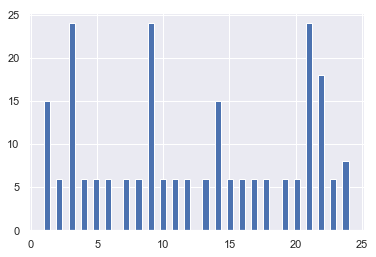

In [7]:
events_df = pd.read_excel(events_path)

print('events_df', events_df.shape)
display(events_df.head())
events_df.FairId.hist(bins=50)

Load Availability

availability_df (1095, 4)


,date_taken,AvailRooms,hotel_rooms,capacity
2462028,2017-01-02,208.0,208.0,1.0
2458465,2017-01-03,208.0,208.0,1.0
2456486,2017-01-04,208.0,208.0,1.0
2462031,2017-01-05,208.0,208.0,1.0
2456488,2017-01-06,208.0,208.0,1.0


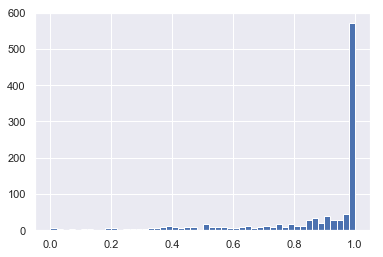

In [8]:
all_files = glob.glob(avail_path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False, sep=',', encoding='utf-16')
    li.append(df)

availability_df = pd.concat(li, axis=0, ignore_index=True)

availability_df['date_taken'] = availability_df['date_taken'].astype(str)

availability_df['capacity'] = availability_df['AvailRooms'] / availability_df['hotel_rooms']
availability_df['capacity'] = availability_df['capacity'].clip(lower=0)

availability_df = availability_df[availability_df['hotel'] == hotel_sel].drop('hotel', axis=1)
availability_df = availability_df.drop('res_date', axis=1).sort_values('date_taken')
availability_df = availability_df.drop_duplicates(subset='date_taken', keep='last')

print('availability_df', availability_df.shape)
display(availability_df.head())
availability_df['capacity'].hist(bins=50)

Load Plan Grouping

In [9]:
plan_grouping_df = pd.read_excel(plangrp_path)
plan_grouping_df.columns = [*plan_grouping_df.columns[:-1], 'plan_code']

print('plan_grouping_df', plan_grouping_df.shape)
display(plan_grouping_df.head())

plan_grouping_df (43, 3)


,Plan_bi_id,plan_desc,plan_code
0,1,half board,HB
1,2,breakfest arr day+hb,HB+
2,3,fb dinner arr day+dinner next,FB+
3,4,fb+lounge,FB
4,5,breakfast board,BB


Focus on relevant attributes + Cleaning

In [10]:
reservations_data2 = reservations_data.copy()

# Focus on a specific hotel:
reservations_data2 = reservations_data2[reservations_data2['hotel'] == hotel_sel]

reservations_data2['date_taken'] = pd.to_datetime(reservations_data2['Date_taken'], errors='coerce')
reservations_data2['date_taken'] = reservations_data2['date_taken'].dt.date.astype(str)

# Clean (filter):
reservations_data2 = reservations_data2[(reservations_data2['m_lead_days']<m_lead_days_max) &
                                        (reservations_data2['room_nights']>room_nights_min) & 
                                        (reservations_data2['room_nights']<room_nights_max) &
                                        (reservations_data2['RoomIncome_Main']>RoomIncome_Main_min) &
                                        (reservations_data2['RoomIncome_Main']<RoomIncome_Main_max)]

# Keep only Singles reservations:
if singles_only:
    singles_ids = [1, 4, 6, 11, 15, 21, 30, 31, 34]
    reservations_data2 = reservations_data2[reservations_data2['market_segment_bi_id'].isin(singles_ids)]

# Keep only fulfilled reservations:
if fulfilled_only:
    fulfilled_ids = ['arriv', 'chkin', 'chkou', 'res']
    reservations_data2 = reservations_data2[reservations_data2['reservation_status'].isin(fulfilled_ids)]

# Extract relevant features only:
reservations_data2 = reservations_data2[['res_date',
                                         'RoomTypes_desc',
                                         'market_segment_bi_id',
                                         'MainCust',
                                         'source',
                                         'sales_channel',
                                         'club_code',
                                         'StatisticSource',
                                         'package_code',
                                         'nationality',
                                         'group_member',
                                         'm_length_of_stay',
                                         'bed_nights',
                                         'm_lead_days',
                                         'adults',
                                         'juniors',
                                         'children',
                                         'babies',
                                         'plan_desc',                                         
                                         'RoomIncome_Main',
                                         'room_nights',
                                         'date_taken']]

# Add 'event_id' sideband feature (for specific hotel):
index_var_dt = pd.to_datetime(reservations_data2[index_var], errors='coerce')
s = index_var_dt.values[:,None]
s1 = events_df['HotelId'].values
s2 = events_df['FromDate'].values
s3 = events_df['ToDate'].values
reservations_data2['event_id'] = (np.dot(((s1==hotel_sel)|(s1==0))&(s>=s2)&(s<=s3), events_df.FairId))
reservations_data2['event_id'] = reservations_data2['event_id'].astype(str)

# Add 'day_of_week' feature:
reservations_data2['day_of_week'] = index_var_dt.dt.day_name()

# Add Availability feature (for specific hotel)
reservations_data2 = pd.merge(reservations_data2, 
                              availability_df[['date_taken','capacity']], 
                              on='date_taken',
                              how='left')
reservations_data2['capacity'] = reservations_data2['capacity'].fillna(1.0)
reservations_data2 = reservations_data2.drop(['date_taken'], axis=1)

# Add Plan Code feature:
reservations_data2 = pd.merge(reservations_data2, 
                              plan_grouping_df[['plan_desc','plan_code']], 
                              on='plan_desc', 
                              how='left')
reservations_data2 = reservations_data2.drop(['plan_desc'], axis=1)

# Mark categorigal features:
reservations_data2['market_segment_bi_id'] = reservations_data2['market_segment_bi_id'].astype(str)

# Dependent variable:
reservations_data2[dependent_var] = (reservations_data2['RoomIncome_Main'] / reservations_data2['room_nights']).fillna(0)
reservations_data2 = reservations_data2.drop(['RoomIncome_Main', 'room_nights'], axis=1)

# Additional cleanup (dependent variable related):
reservations_data2 = reservations_data2[(reservations_data2[dependent_var] < dependent_var_max)]

Reservation dataframe finalization:

In [11]:
# Reservations dataframe finalization
reservations_df = reservations_data2.copy()
reservations_df[index_var] = pd.to_datetime(reservations_df[index_var])
reservations_df = reservations_df.set_index(index_var)
reservations_df = reservations_df.sort_index()
reservations_df = reservations_df.drop_duplicates()

# Add a synthetic time (unique)
reservations_df = reservations_df.set_index(pd.to_datetime(reservations_df.index) + 
                                            pd.to_timedelta(reservations_df.groupby(level=0).cumcount(), unit='s'))

Data Cleaning (fillna, per column)

In [12]:
for col in reservations_df:
    dt = reservations_df[col].dtype 
    if dt == int or dt == float:
        reservations_df[col] = reservations_df[col].fillna(0)
    else:
        reservations_df[col] = reservations_df[col].fillna("")

Debug mixed types cases

In [13]:
%%script false --no-raise-error

df = pd.DataFrame(reservations_df['nationality'])
weird = (df.applymap(type) != df.iloc[0].apply(type)).any(axis=1)
display(df[weird])

<hr>

# Data Exploration

### Quick look:

In [14]:
print('reservations_df shape: %s' % str(reservations_df.shape))
display(reservations_df.head())

reservations_df shape: (64250, 22)


,RoomTypes_desc,market_segment_bi_id,MainCust,source,sales_channel,club_code,StatisticSource,package_code,nationality,group_member,...,m_lead_days,adults,juniors,children,babies,event_id,day_of_week,capacity,plan_code,ARR
2018-01-01 00:00:00,deluxe pool view,4.0,8587.0,t.a.,home site,,,,rus,0.0,...,36.0,1.0,0.0,0.0,0.0,0,Monday,0.711538,BB,1135.30
2018-01-01 00:00:01,deluxe suite,4.0,12346.0,slf,,,,,isr,0.0,...,2.0,2.0,0.0,0.0,1.0,0,Monday,0.706731,BB,2519.78
2018-01-01 00:00:02,herzliya room,4.0,9219.0,t.a.,,platinum,,,usa,0.0,...,0.0,1.0,0.0,0.0,0.0,0,Monday,0.923077,BB,1048.54
2018-01-01 00:00:03,deluxe sea view,15.0,9701.0,co,,platinum,,,isr,0.0,...,1.0,1.0,0.0,0.0,0.0,0,Monday,0.975962,BB,745.40
2018-01-01 00:00:04,herzliya room,40.0,7936.0,slf,,,,,ind,0.0,...,0.0,1.0,0.0,0.0,0.0,0,Monday,0.822115,BB,701.49


In [15]:
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64250 entries, 2018-01-01 00:00:00 to 2019-12-31 00:00:25
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RoomTypes_desc        64250 non-null  object 
 1   market_segment_bi_id  64250 non-null  object 
 2   MainCust              64250 non-null  float64
 3   source                64250 non-null  object 
 4   sales_channel         64250 non-null  object 
 5   club_code             64250 non-null  object 
 6   StatisticSource       64250 non-null  object 
 7   package_code          64250 non-null  object 
 8   nationality           64250 non-null  object 
 9   group_member          64250 non-null  float64
 10  m_length_of_stay      64250 non-null  float64
 11  bed_nights            64250 non-null  float64
 12  m_lead_days           64250 non-null  float64
 13  adults                64250 non-null  float64
 14  juniors               64250 non-nul

Dependent variable overview:

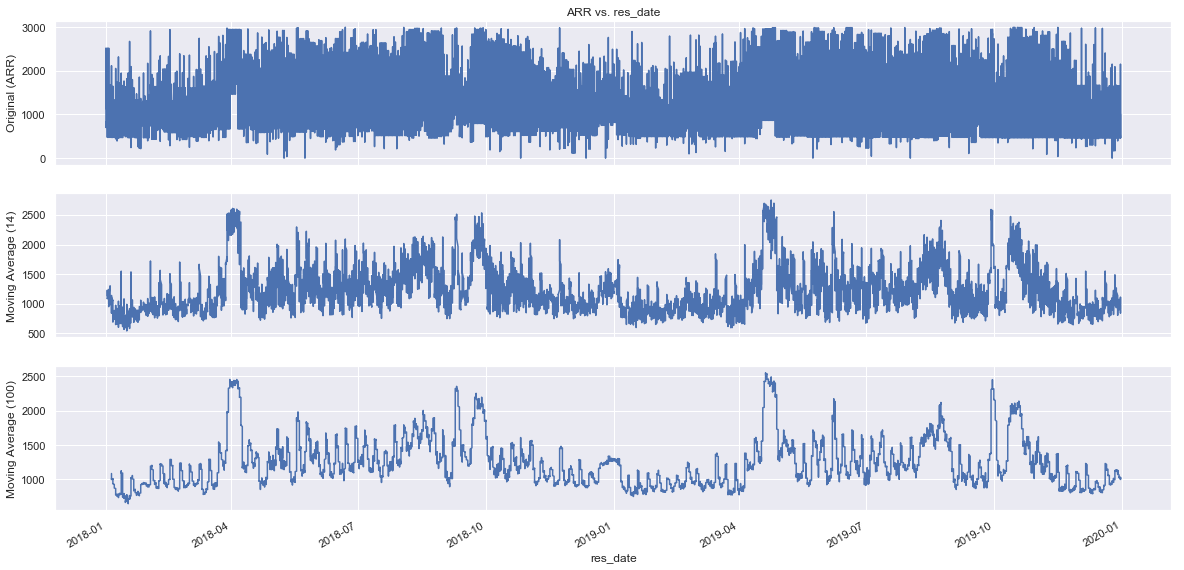

In [16]:
x = reservations_df.index.unique()
y1 = reservations_df[dependent_var].groupby(reservations_df.index).mean()
y2 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=14).mean()
y3 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=100).mean()

fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)
ax[2].xaxis_date()
fig.autofmt_xdate()
ax[2].set_xlabel(index_var)
ax[0].set_ylabel('Original (%s)' % dependent_var)
ax[1].set_ylabel('Moving Average (14)')
ax[2].set_ylabel('Moving Average (100)')
ax[0].set_title('%s vs. %s' % (dependent_var,index_var))
plt.show()

### Encode the dataset

In [17]:
encoded_pre_df = reservations_df.drop([dependent_var], axis=1)

# Label Encoding:
enc_lbl = LabelEncoder()
encoded_categorical_df = encoded_pre_df.select_dtypes(include=['object']).apply(enc_lbl.fit_transform)

# OneHot Encoding:
enc_oh = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_oh_df = pd.DataFrame(enc_oh.fit_transform(encoded_categorical_df).toarray(), 
                                         index=reservations_df.index)
encoded_categorical_oh_df.columns = enc_oh.get_feature_names(encoded_categorical_df.columns)

# Numerical Features:
encoded_numerical_df = encoded_pre_df.select_dtypes(exclude=['object'])

# Merge back into a single dataframe:
encoded_df = pd.concat([encoded_categorical_oh_df, encoded_numerical_df], axis=1, sort=False)
    
print('Features (after encoding):\n')
print(encoded_df.shape)
display(encoded_df.head())
display(encoded_df.describe())

Features (after encoding):

(64250, 245)


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity
2018-01-01 00:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8587.0,0.0,8.0,1.0,36.0,1.0,0.0,0.0,0.0,0.711538
2018-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,12346.0,0.0,11.0,2.0,2.0,2.0,0.0,0.0,1.0,0.706731
2018-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9219.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.923077
2018-01-01 00:00:03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9701.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.975962
2018-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7936.0,0.0,19.0,1.0,0.0,1.0,0.0,0.0,0.0,0.822115


,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity
count,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,...,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000,64250.000000
mean,0.000016,0.003237,0.062039,0.041105,0.170973,0.001323,0.015767,0.079315,0.626210,0.000016,...,8963.830210,0.116125,5.420623,1.526179,34.728872,1.357588,0.000093,0.168498,0.042428,0.817474
std,0.003945,0.056806,0.241228,0.198535,0.376488,0.036349,0.124572,0.270232,0.483813,0.003945,...,2879.454421,0.320377,4.772718,0.732853,48.788619,0.567083,0.009663,0.535700,0.213271,0.241873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7882.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.725962
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,9701.000000,0.000000,4.000000,1.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.923077
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,10524.250000,0.000000,7.000000,2.000000,40.000000,2.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,13186.000000,1.000000,96.000000,4.000000,298.000000,4.000000,1.000000,4.000000,3.000000,1.000000


### Histogram Analysis

Dependent variable histogram

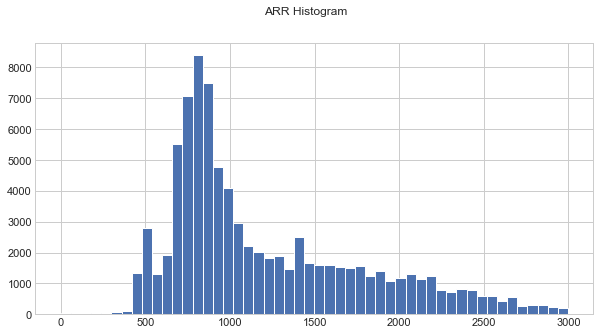

ARR min, mean, max = 0.01, 1208.24, 2997.72
ARR uniques (10723):
 [1.00000e-02 3.00000e-02 2.70000e-01 ... 2.99442e+03 2.99733e+03
 2.99772e+03]


In [18]:
plt.style.use('seaborn-whitegrid')
reservations_data2[dependent_var].hist(bins=50, figsize=(10,5))
plt.suptitle('%s Histogram' % dependent_var)
plt.show()

s = reservations_data2[dependent_var]
s_unique = np.sort(s.unique())
print('%s min, mean, max = %.2f, %.2f, %.2f' % (dependent_var,min(s),np.mean(s),max(s)))
print('%s uniques (%d):\n %s' % (dependent_var, len(s_unique), str(s_unique)))

Features Histograms

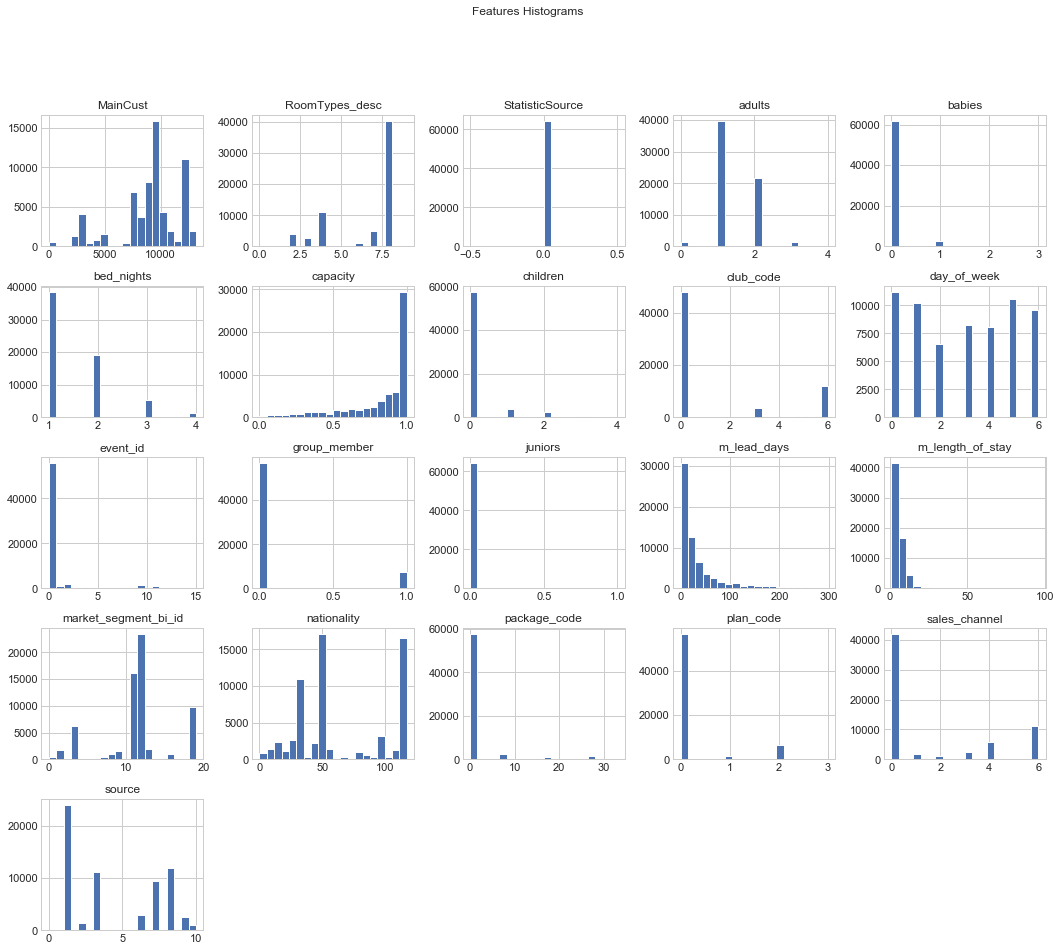

In [19]:
plt.style.use('seaborn-whitegrid')
encoded_hist_df = pd.concat([encoded_categorical_df, encoded_numerical_df], axis=1, sort=False)
encoded_hist_df.hist(bins=20, figsize=(18,15))
plt.suptitle('Features Histograms')
plt.show()

### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.<br>
The __Pearson__ and __Spearman__ correlation coefficients can range in value from −1 to +1 ([link](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).<br>
The __Pearson__ correlation evaluates the __linear__ relationship between two continuous variables.<br>
The __Spearman__ correlation evaluates the __monotonic__ relationship between two continuous or ordinal variables.

In [20]:
dependent_series = reservations_df[dependent_var]
encoded_df2 = pd.concat([encoded_df, dependent_series], axis=1)

Relevant Features (Pearson):

day_of_week_0              0.201947
event_id_1                 0.206361
m_lead_days                0.256861
club_code_6                0.263213
package_code_0             0.266951
RoomTypes_desc_2           0.273567
event_id_0                 0.275210
sales_channel_6            0.288943
source_3                   0.289402
market_segment_bi_id_3     0.294071
club_code_0                0.297308
source_7                   0.325489
market_segment_bi_id_19    0.327287
children                   0.350499
sales_channel_4            0.381125
source_8                   0.421714
RoomTypes_desc_7           0.464580
adults                     0.475348
market_segment_bi_id_12    0.480784
source_1                   0.490117
market_segment_bi_id_11    0.603820
RoomTypes_desc_8           0.615287
bed_nights                 0.623931
ARR                        1.000000
Name: ARR, dtype: float64 

Relevant Features (Spearman):

nationality_49             0.206950
plan_code_0

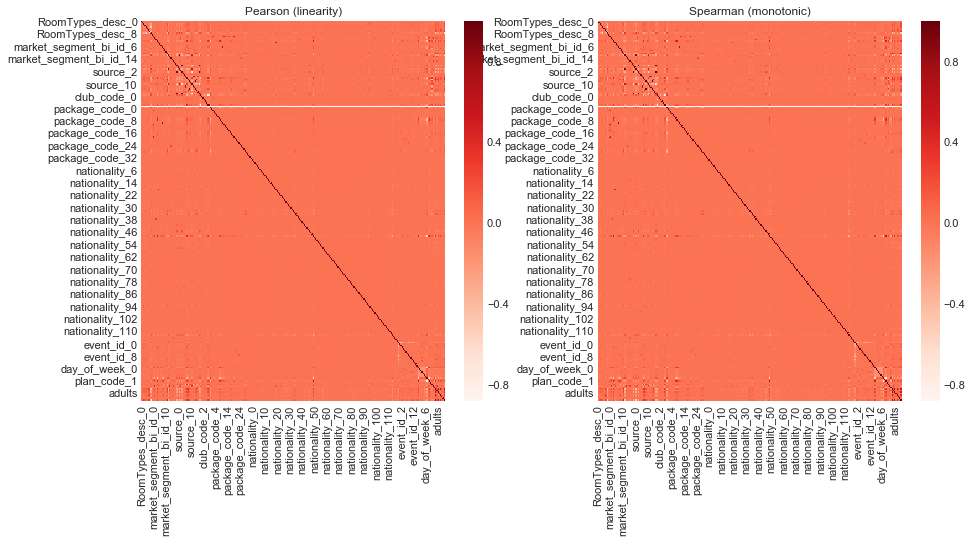

In [21]:
pearson_cor = encoded_df2.corr(method='pearson')
spearman_cor = encoded_df2.corr(method='spearman')

# Highlight relevant features
pearson_cor_targets = abs(pearson_cor[dependent_var])
spearman_cor_targets = abs(spearman_cor[dependent_var])
print('Relevant Features (Pearson):\n')
print(pearson_cor_targets[pearson_cor_targets > 0.2].sort_values(), '\n')
print('Relevant Features (Spearman):\n')
print(spearman_cor_targets[spearman_cor_targets > 0.2].sort_values())

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_cor, ax=ax1, annot=False, cmap=plt.cm.Reds)
sns.heatmap(spearman_cor, ax=ax2, annot=False, cmap=plt.cm.Reds)
ax1.set_title('Pearson (linearity)')
ax2.set_title('Spearman (monotonic)')
plt.show()

In [22]:
%%script false --no-raise-error

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(pearson_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Pearson (monotonic)')
plt.show()

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(spearman_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Spearman (monotonic)')
plt.show()

<hr>

# Auxiliary Methods

In [23]:
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')

    print('CV Mean Accuracy: ', np.mean(scores))
    print('CV STD Accuracy: ', np.std(scores), '\n')

In [24]:
def plot_model_results(model, X_train, X_test, y_train, y_test, y_pred):

    y_pred_train = model.predict(X_train)

    y_trn_smp = pd.DataFrame(y_train, index=X_train.index)
    y_trn_prd = pd.DataFrame(y_pred_train, index=X_train.index)
    y_tst_smp = pd.DataFrame(y_test, index=X_test.index)
    y_tst_prd = pd.DataFrame(y_pred, index=X_test.index)

    y_trn_smp_ma = y_trn_smp.groupby(y_trn_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_trn_prd_ma = y_trn_prd.groupby(y_trn_prd.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_smp_ma = y_tst_smp.groupby(y_tst_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_prd_ma = y_tst_prd.groupby(y_tst_prd.index).mean().rolling(window=14).mean().fillna(0)
    
    y_trn_ma = pd.concat([y_trn_smp_ma, y_trn_prd_ma], axis=1)
    y_trn_ma.columns = ['Sampled', 'Predicted']
    
    y_tst_ma = pd.concat([y_tst_smp_ma, y_tst_prd_ma], axis=1)
    y_tst_ma.columns = ['Sampled', 'Predicted']    
    
    # Figure 1:
    plt.figure(figsize=(20,12))
    
    plt.subplot(221)
    plt.scatter(y_train, y_pred_train)
    plt.plot(y_train, y_train, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Train-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.subplot(222)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Test-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.show()
    
    # Figure 2:
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    y_trn_ma.plot(ax=ax[0], linewidth=1)
    ax[0].xaxis_date()
    ax[0].set_title('Train-Set - Sampled vs. Predicted (MA=14)')
    ax[0].set_xlabel('Time')
    ax[0].legend()

    y_tst_ma.plot(ax=ax[1], linewidth=1)
    ax[1].xaxis_date()
    ax[1].set_title('Test-Set - Sampled vs. Predicted (MA=14)')
    ax[1].set_xlabel('Time')
    ax[1].legend()

    fig.autofmt_xdate()

    plt.show()

In [25]:
def plot_tree_features_importance(feature_importances, feature_labels, threshold):
    feature_import_val = feature_importances[feature_importances > threshold]
    feature_import_lbl = feature_labels[feature_importances > threshold]

    plt.figure(figsize=(12,6))
    plt.bar(feature_import_lbl, feature_import_val)
    plt.xticks(rotation='vertical')
    plt.title('Features Importance')
    plt.show()

In [26]:
def plot_permutation_importance(model, X, y, topN, n_repeats=10, random_state=42):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    feature_import_val = result.importances[perm_sorted_idx].T[:,-topN:]
    feature_import_lbl = X.columns[perm_sorted_idx][-topN:]

    plt.figure(figsize=(12,6))
    plt.boxplot(feature_import_val, vert=False, labels=feature_import_lbl)
    plt.xticks(rotation='vertical')
    plt.title('Permutation Importance')
    plt.show()

In [27]:
def plot_partial_dependencies(model, X, target_features):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies")
    plot_partial_dependence(model, X, target_features, ax=ax, line_kw={"c": "red"})

In [28]:
def plot_partial_2d_dependencies(model, X, target_feature1, target_feature2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies, 2D")
    plot_partial_dependence(model, 
                            X,
                            [(list(X.columns).index(target_feature1),
                              list(X.columns).index(target_feature2))],
                            n_jobs=3,
                            grid_resolution=20,
                            ax=ax)

In [29]:
def plot_learning_curve(history):

    fig, axes = plt.subplots(1, 1, figsize=(20,10))
    axes.plot(history['loss'], 'b', label='Train', linewidth=2)
    axes.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    axes.set_title('Learning Curve', fontsize=20)
    axes.set_ylabel('Loss (mae)', fontsize=15)
    axes.set_xlabel('Epoch', fontsize=15)
    axes.legend(loc='upper right')
    plt.show()

In [30]:
def print_model_accuracy(model, X_train, y_train, X_test, y_test):
    score_trn = model.score(X_train, y_train) if abs(model.score(X_train, y_train))<=1 else 0
    score_tst = model.score(X_test, y_test) if abs(model.score(X_test, y_test))<=1 else 0
    print('Train Accuracy: ', score_trn)
    print('Test Accuracy: ', score_tst)

<hr>

# Basic Modelling

Linear Modelling:

![](https://miro.medium.com/max/1400/1*0W935wbGEcLZoqXIxkuhTQ.png)

### Normalization

In [31]:
scaler = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
encoded_scl_df = pd.DataFrame(scaler.fit_transform(encoded_df), 
                              index=encoded_df.index,
                              columns=encoded_df.columns)

encoded_scl_df.describe()

,RoomTypes_desc_0,RoomTypes_desc_1,RoomTypes_desc_2,RoomTypes_desc_3,RoomTypes_desc_4,RoomTypes_desc_5,RoomTypes_desc_6,RoomTypes_desc_7,RoomTypes_desc_8,RoomTypes_desc_9,...,MainCust,group_member,m_length_of_stay,bed_nights,m_lead_days,adults,juniors,children,babies,capacity
count,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,...,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04,6.425000e+04
mean,-1.658855e-19,-3.981251e-18,3.096529e-18,-1.857917e-17,-8.139447e-17,2.344515e-17,-1.725209e-17,-3.538890e-18,8.139447e-17,5.529515e-20,...,-1.619042e-16,8.758752e-17,-5.308335e-17,3.361945e-17,4.600557e-17,-1.114750e-16,8.847225e-19,3.804307e-17,2.034862e-17,4.812890e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-3.945180e-03,-5.699007e-02,-2.571815e-01,-2.070437e-01,-4.541288e-01,-3.639656e-02,-1.265666e-01,-2.935098e-01,-1.294334e+00,-3.945180e-03,...,-3.113750e+00,-3.624653e-01,-9.262346e-01,-7.179924e-01,-7.118288e-01,-2.394001e+00,-9.664054e-03,-3.145404e-01,-1.989408e-01,-3.379792e+00
25%,-3.945180e-03,-5.699007e-02,-2.571815e-01,-2.070437e-01,-4.541288e-01,-3.639656e-02,-1.265666e-01,-2.935098e-01,-1.294334e+00,-3.945180e-03,...,-3.757096e-01,-3.624653e-01,-5.071830e-01,-7.179924e-01,-6.093450e-01,-6.305780e-01,-9.664054e-03,-3.145404e-01,-1.989408e-01,-3.783507e-01
50%,-3.945180e-03,-5.699007e-02,-2.571815e-01,-2.070437e-01,-4.541288e-01,-3.639656e-02,-1.265666e-01,-2.935098e-01,7.725983e-01,-3.945180e-03,...,2.560122e-01,-3.624653e-01,-2.976571e-01,-7.179924e-01,-3.838809e-01,-6.305780e-01,-9.664054e-03,-3.145404e-01,-1.989408e-01,4.366102e-01
75%,-3.945180e-03,-5.699007e-02,-2.571815e-01,-2.070437e-01,-4.541288e-01,-3.639656e-02,-1.265666e-01,-2.935098e-01,7.725983e-01,-3.945180e-03,...,5.419193e-01,-3.624653e-01,3.309204e-01,6.465478e-01,1.080410e-01,1.132845e+00,-9.664054e-03,-3.145404e-01,-1.989408e-01,7.546438e-01
max,2.534739e+02,1.754692e+01,3.888305e+00,4.829897e+00,2.202018e+00,2.747512e+01,7.900979e+00,3.407041e+00,7.725983e-01,2.534739e+02,...,1.466320e+00,2.758885e+00,1.897872e+01,3.375628e+00,5.396201e+00,4.659690e+00,1.034762e+02,7.152380e+00,1.386776e+01,7.546438e-01


### Cross Validation (Train/Test split)

R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are the most commonly used metrics to measure accuracy for continuous variables.<br>
The focus here is on R-Squared, aka the coefficient of determination, which implies how much variance in the target variable can be explained by the model.<br>
Values can range from 0 to 1. Higher values indicate a model that is highly predictive.<br>
For example, a R² value of 0.80 means that the model is accounting for 80% of the variability in the data.<br>
In general, the higher the R² value the better. However, a very high R² could be a sign of overfitting. <br>
Low values indicate that our model is not very good at predicting the target.<br>

<div><img src="https://miro.medium.com/max/2000/1*RZ7wWxTZxb6ySGGWJaY-CQ.jpeg" width=800"/></div>

Split the data into training and testing with a ratio of 80% and 20%

In [32]:
X_train, X_test, y_train, y_test = train_test_split(encoded_scl_df, 
                                                    dependent_series, 
                                                    test_size=cv_ratio, 
                                                    random_state=27,
                                                    shuffle=False)   # essential for TimeSeries

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

X_train.index = X_train.index.rename(index_var)
X_test.index = X_test.index.rename(index_var)
y_train.index = y_train.index.rename(index_var)
y_test.index = y_test.index.rename(index_var)

Prepare a combined Xy version as well

In [33]:
scaler_xy_train = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
scaler_xy_test = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()

Xy_train = X_train.copy()
Xy_train[dependent_var] = y_train.values
Xy_train = pd.DataFrame(scaler_xy_train.fit_transform(Xy_train),
                        index=Xy_train.index,
                        columns=Xy_train.columns)

Xy_test = X_test.copy()
Xy_test[dependent_var] = y_test.values
Xy_test = pd.DataFrame(scaler_xy_test.fit_transform(Xy_test),
                       index=Xy_test.index,
                       columns=Xy_test.columns)

<hr>

### Linear Regressor

Linear regression finds the parameters to minimize the mean squared error or residuals between the predictions and the targets.<br>

<div><img src="https://gohantimes.com/wp-content/uploads/2019/11/ols-sum-of-square-diff.png" width="500"/></div>

Model: linear_regressor
CV Mean Accuracy:  -4.686819037014692e+25
CV STD Accuracy:  4.471121514680473e+25 

Train Accuracy:  0.7982521813911921
Test Accuracy:  0


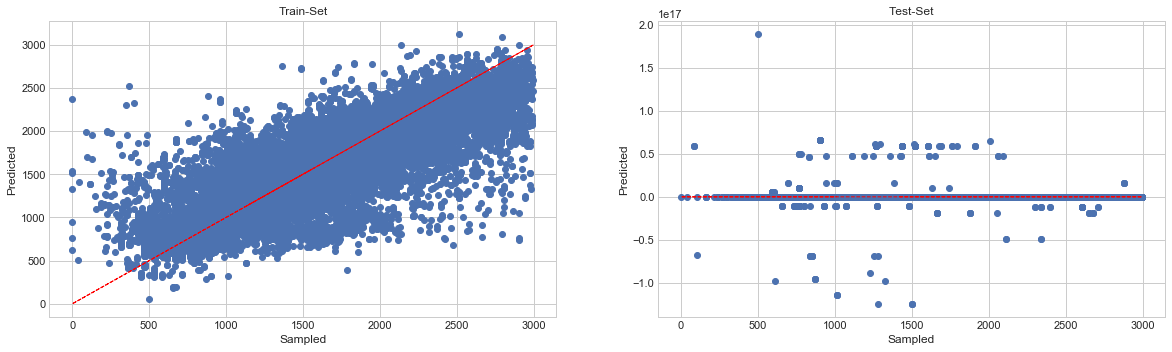

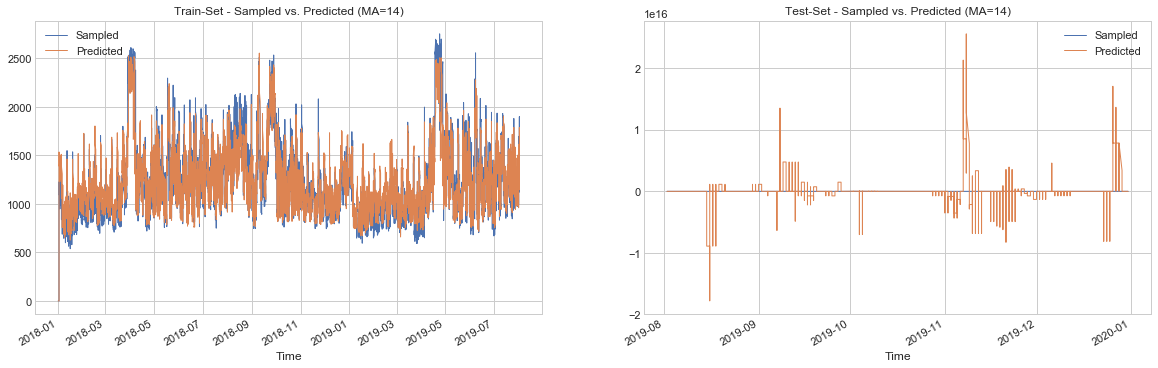

In [34]:
model_name = models[0]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = LinearRegression(n_jobs=4)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Examine the coefficients:

In [35]:
for coef, col in enumerate(X_train.columns[:10]):
    print('%s --> %.2f' % (col, model.coef_[coef]))

RoomTypes_desc_0 --> -3685893812502.46
RoomTypes_desc_1 --> -53073013020664.32
RoomTypes_desc_2 --> -225375787665132.38
RoomTypes_desc_3 --> -185488040599762.31
RoomTypes_desc_4 --> -351747184155807.12
RoomTypes_desc_5 --> -33960040172293.53
RoomTypes_desc_6 --> -116385797045819.88
RoomTypes_desc_7 --> -252473849196827.62
RoomTypes_desc_8 --> -452018881580809.88
RoomTypes_desc_9 --> -272187557543177.44


#### Plot Partial Dependencies (PDP)
Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.<br> X-axis represents the 'target feature', while y-axis represents the model prediction.<br>
[reference](https://www.kaggle.com/dansbecker/partial-dependence-plots)

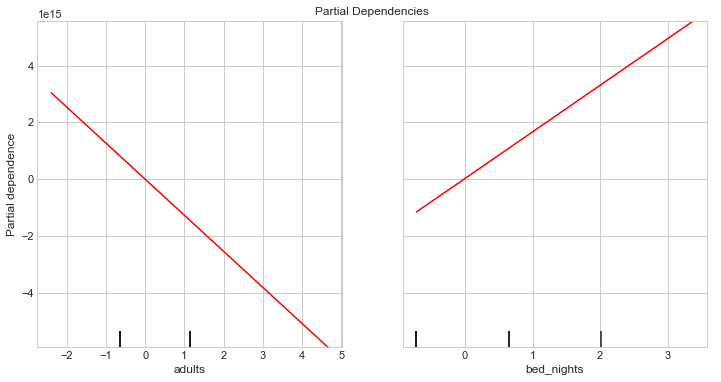

In [36]:
plot_partial_dependencies(model, X_train, ["adults", "bed_nights"])

We can clearly see a linear relationship among these featrues.<br>
Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

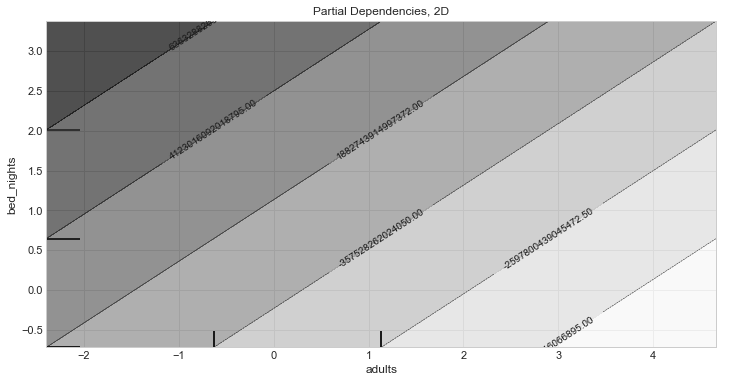

In [37]:
plot_partial_2d_dependencies(model, X_train, "adults", "bed_nights")

#### Permutation Importance
“Permutation importance” is model-agnostic variable importance approach, so they do not require a single variable-related discrete training process like decision tree. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.<br>
[reference](https://scikit-learn.org/stable/modules/permutation_importance.html)

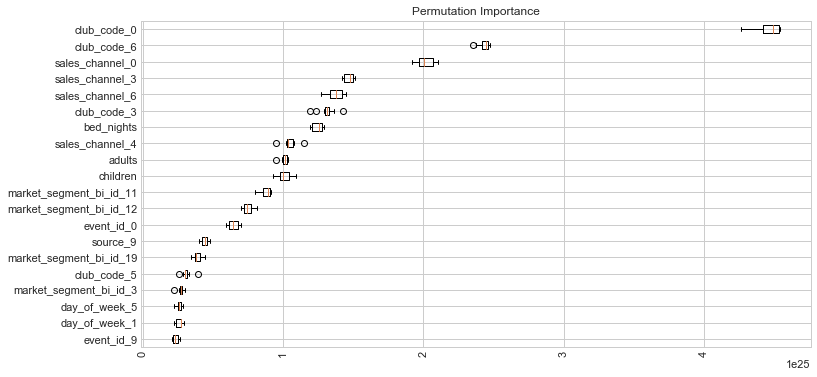

In [38]:
plot_permutation_importance(model, X_test, y_test, 20)

<hr>

### Ridge Regressor

Ridge regression uses L2 regularization to minimize the magnitude of the coefficients.<br>
It reduces the size of the coefficients and helps reduce model complexity.<br>
We control the complexity of our model with the regularization parameter, ⍺.<br>
Higher values of ⍺ force coefficients to move towards zero and increases the restriction on the model.<br>
This decreases training performance, but also increases the generalizability of the model. 

Model: ridge_regressor
CV Mean Accuracy:  0.7278860715888289
CV STD Accuracy:  0.06978661751911437 

Train Accuracy:  0.8004623836478884
Test Accuracy:  0.8039914057724085


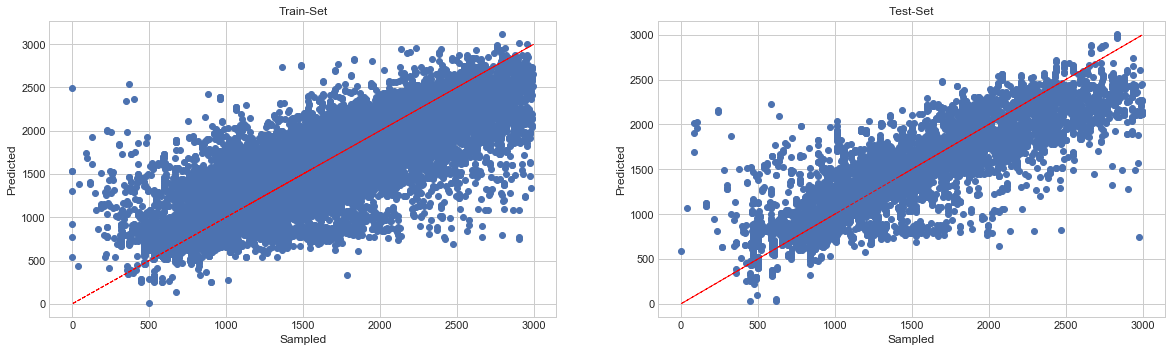

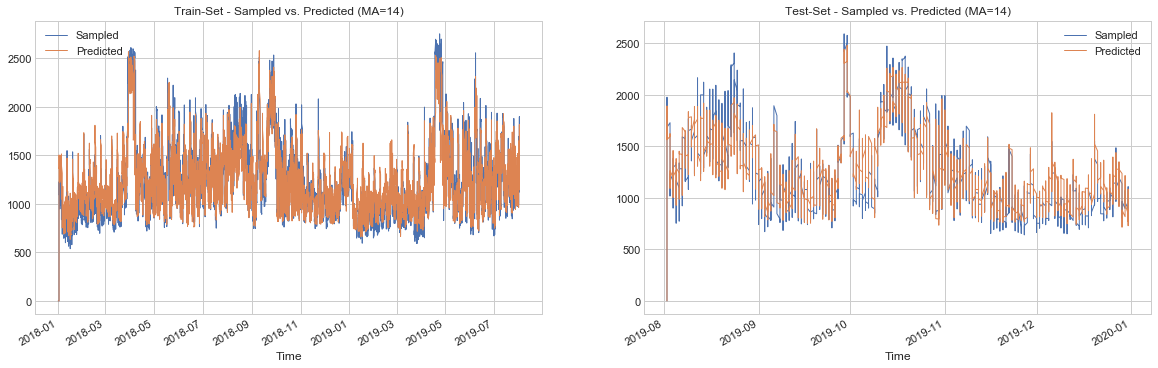

In [39]:
model_name = models[1]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = Ridge(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)    
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### Lasso Regressor

Lasso regression uses L1 regularization to force some coefficients to be exactly zero.<br>
This means some features are completely ignored by the model. <br>
This can be thought of as a type of automatic feature selection!<br>
Lasso can be a good model choice when we have a large number of features but expect only a few to be important.<br>
Higher values of ⍺ force more coefficients to zero and can cause underfitting.<br>
Lower values of alpha lead to fewer non-zero features and can cause overfitting.<br>
Very low values of alpha will cause the model to resemble linear regression.

Model: lasso_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3110362.3802027702, tolerance: 1455124.7015401477



CV Mean Accuracy:  0.7304199300703973
CV STD Accuracy:  0.06748043311508009 

Train Accuracy:  0.8004499732013426
Test Accuracy:  0.8027765566602939


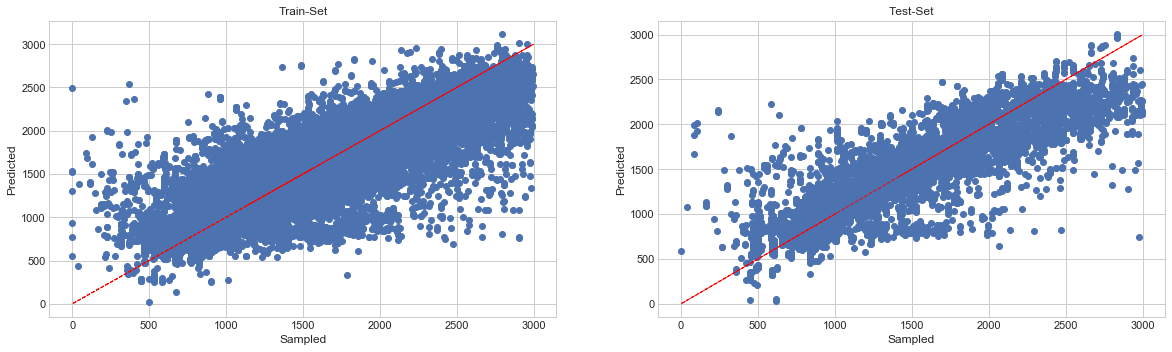

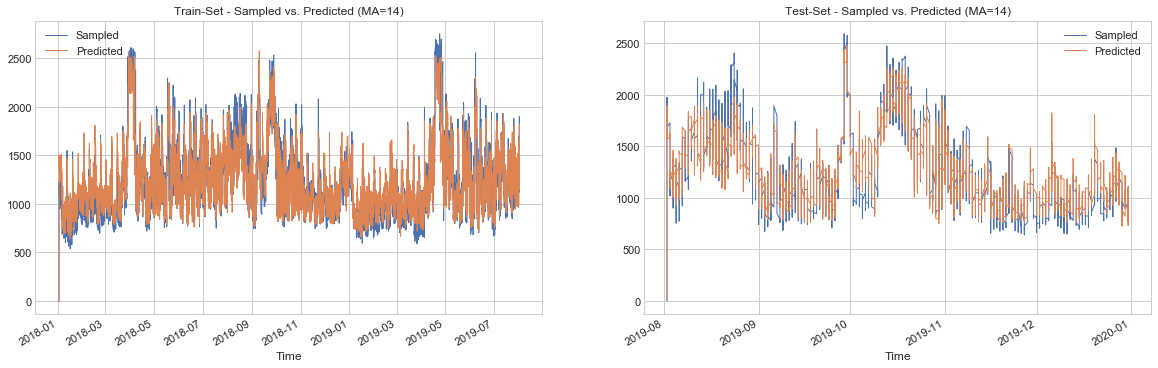

In [40]:
model_name = models[2]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = Lasso(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### Elastic-Net Regressor

Elastic-net is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2).<br>

<div><img src="https://miro.medium.com/max/1312/1*oECWmvwOKotaAA0czR30vg.png" width="500"/></div>

Model: elasticnet_regressor
CV Mean Accuracy:  0.7195630959144228
CV STD Accuracy:  0.06066576471472238 

Train Accuracy:  0.7778526449118992
Test Accuracy:  0.7624074802976639


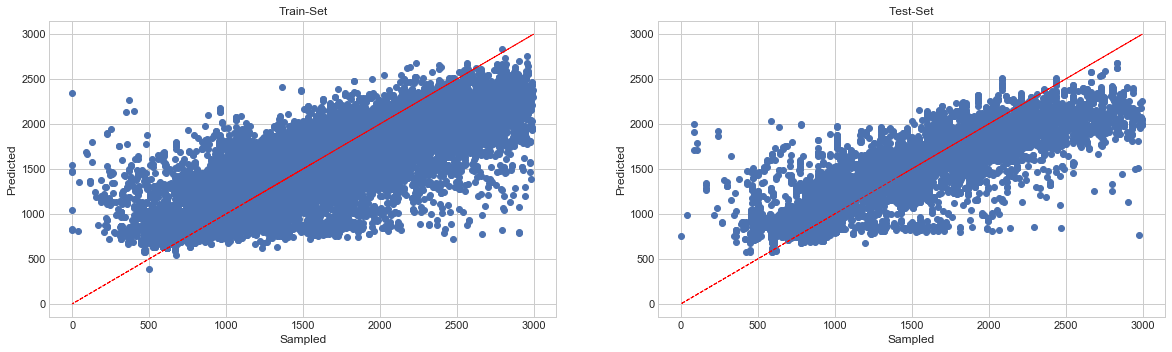

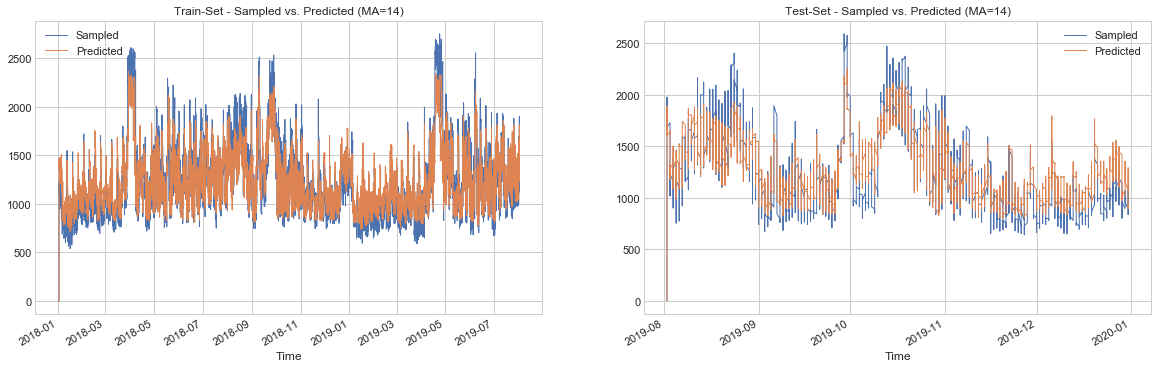

In [41]:
model_name = models[3]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = ElasticNet(alpha=1, l1_ratio=0.5)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

### Support Vector Regressor

The method of Support Vector Classification can be extended to solve regression problems, termed as Support Vector Regression.<br>
The model produced by support vector classification (classic SVM) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin.<br>
Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.<br>
In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold<br>

<div><img src="https://miro.medium.com/max/1400/1*rs0EfF8RPVpgA-EfgAq85g.jpeg" width="500"/></div>

Model: supportvect_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed

CV Mean Accuracy:  0.4851217485317852
CV STD Accuracy:  0.33810004121944637 

Train Accuracy:  0.7951476187953073
Test Accuracy:  0.7015832898392929


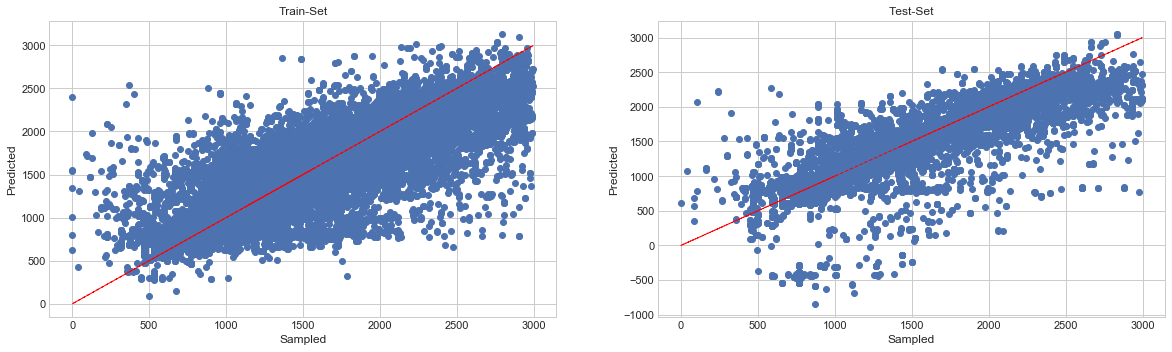

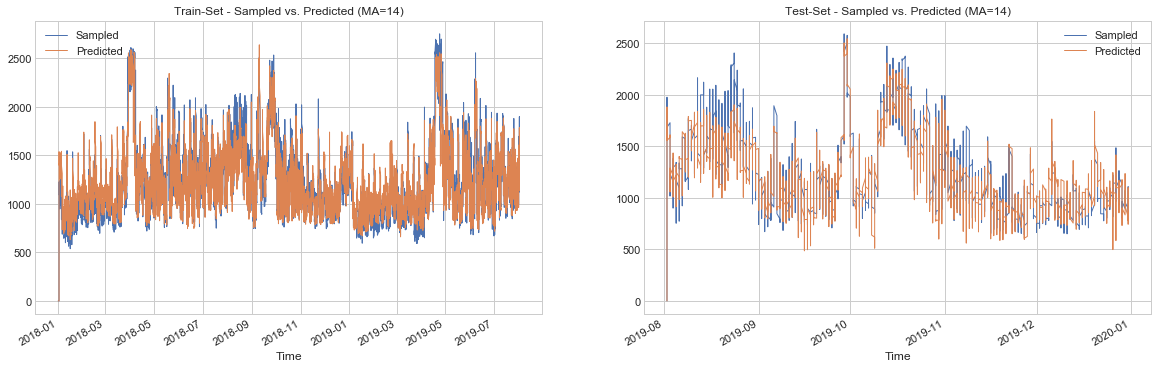

In [42]:
model_name = models[4]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = LinearSVR(random_state=0, tol=1e-5)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

# Trees

### Decision Tree Regressor

<div><img src="https://miro.medium.com/max/1630/1*XZ220vTa7rN8ccJZZNe09w.png" width="500"/></div>

Model: decisiontree_regressor
CV Mean Accuracy:  0.5595419682901601
CV STD Accuracy:  0.06779939124046867 

Train Accuracy:  0.9939999808700719
Test Accuracy:  0.5724494522304785


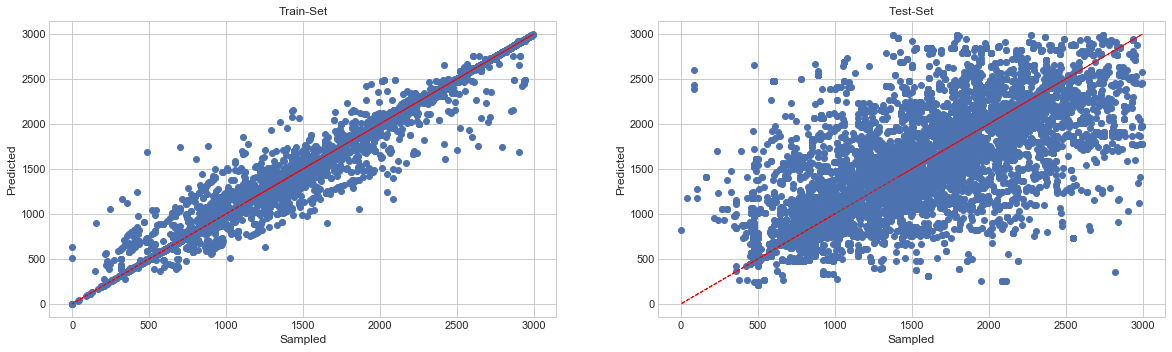

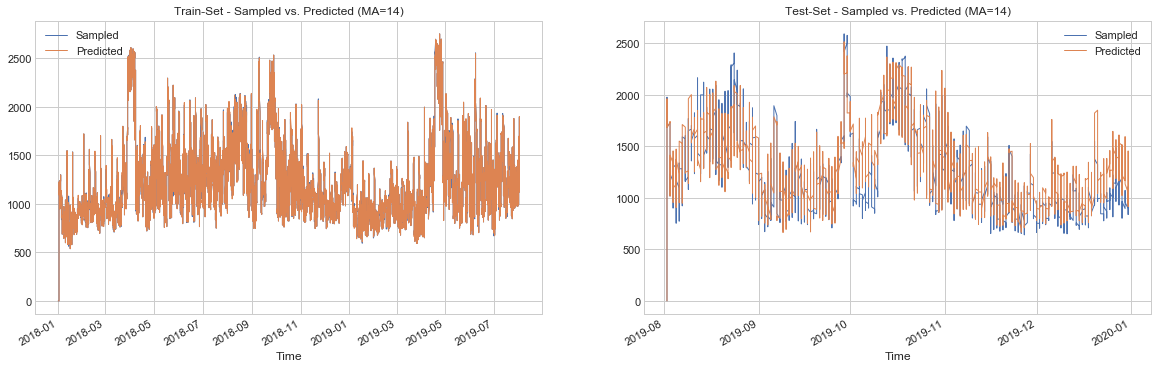

In [43]:
model_name = models[5]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = DecisionTreeRegressor(random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

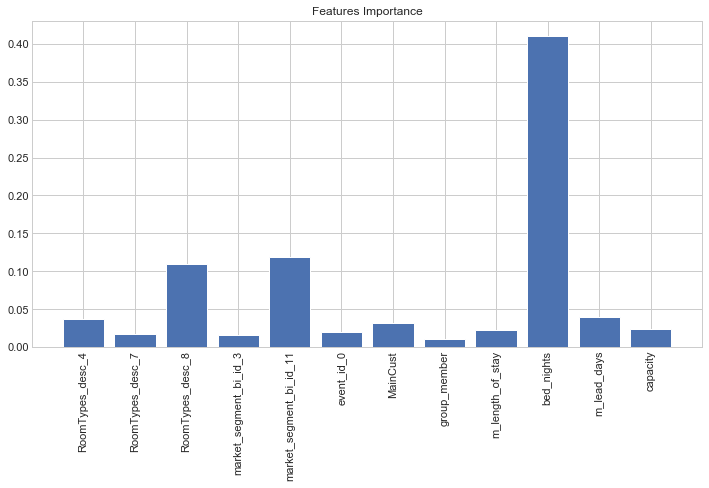

In [44]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

Tree Visualization

In [45]:
%%script false --no-raise-error

plot_tree(model)

<hr>

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting<br>

<div><img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" width="500"/></div>

Model: randomforest_regressor
CV Mean Accuracy:  0.5407546046591305
CV STD Accuracy:  0.1171387281487412 

Train Accuracy:  0.5824284020464341
Test Accuracy:  0.5868186813950169


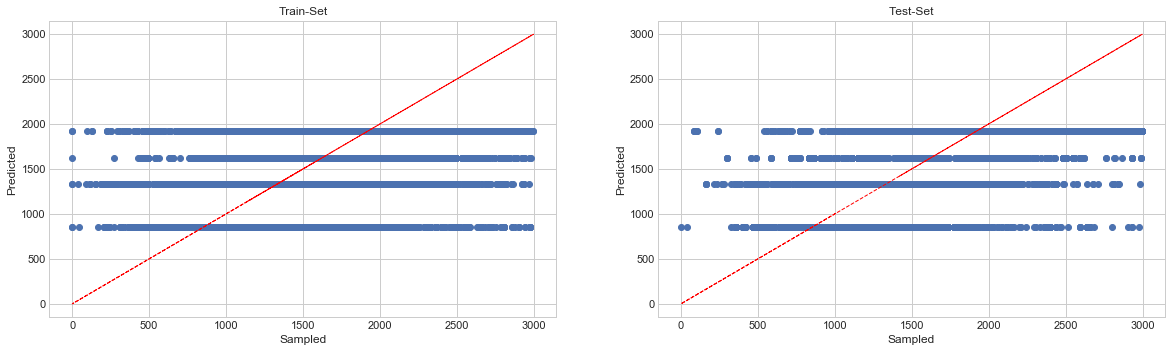

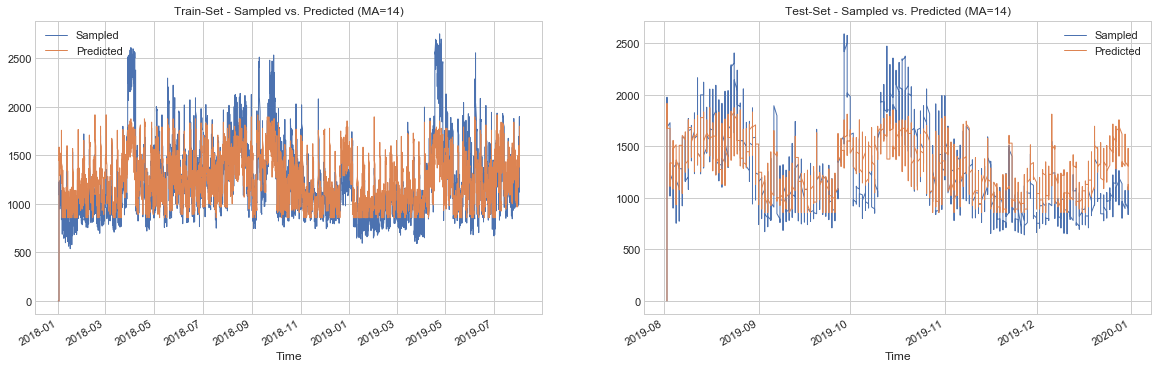

In [46]:
model_name = models[6]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = RandomForestRegressor(max_depth=2, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

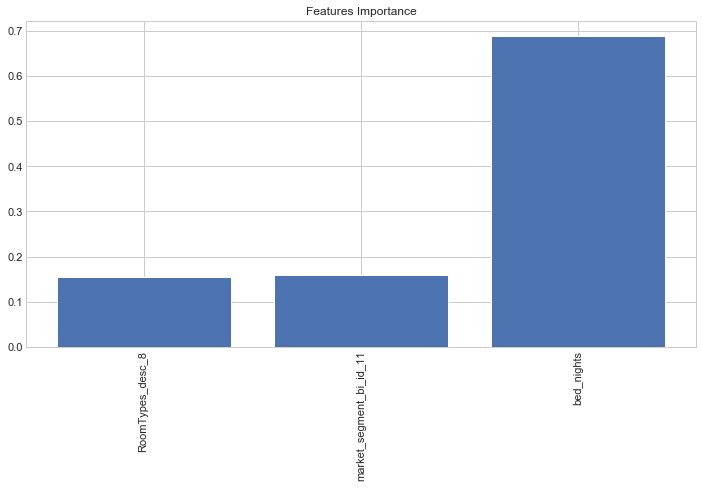

In [47]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

<hr>

### XGBoost Regressor

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.<br>

<div><img src="https://miro.medium.com/max/1000/0*tzKt_ABz5rRrsGoW.jpg" width="500"/></div>

Model: xgboost_regressor
CV Mean Accuracy:  0.7472648640512972
CV STD Accuracy:  0.06847867356199562 

Train Accuracy:  0.8275847726338341
Test Accuracy:  0.7912379471353029


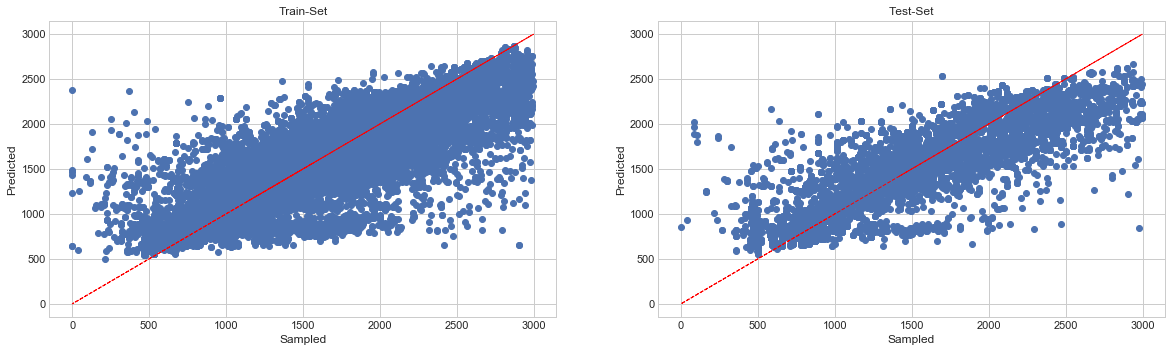

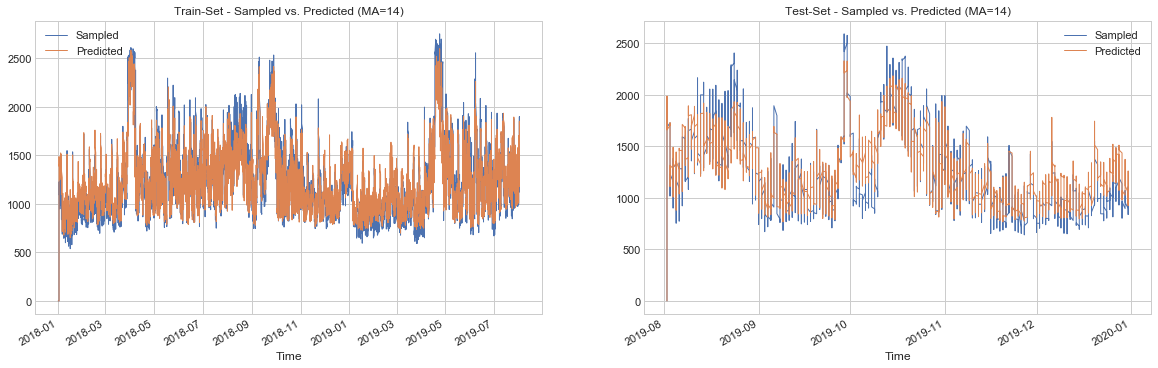

Base Score:  0.5


In [48]:
model_name = models[7]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'max_depth': [2,4,6],
                              'n_estimators': [50,100,200]}, 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)
    
print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

print('Base Score: ', model.base_score)

Feature Importances

Text(0.5, 1.0, 'Features Importance')

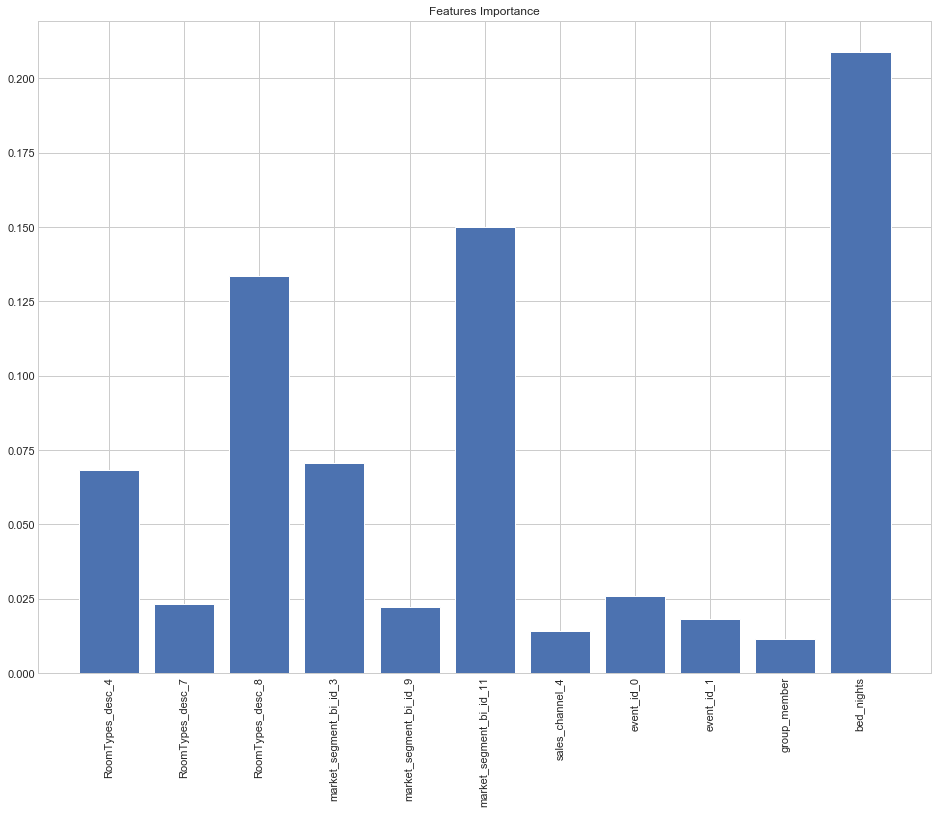

In [49]:
feature_import_thr = 0.01
feature_import_val = model.feature_importances_[model.feature_importances_ > feature_import_thr]
feature_import_lbl = X_train.columns[model.feature_importances_ > feature_import_thr]

plt.figure(figsize=(16,12))
plt.bar(feature_import_lbl, feature_import_val)
plt.xticks(rotation='vertical')
plt.title('Features Importance')

<hr>

# Neural Networks

### Multi-layer Perceptron

A Multi-layer Perceptron (MLP) Regression System is a multilayer feedforward neural network training system that implements multi-layer perceptron regression algorithm to solve a Multi-layer Perceptron Regression Task.<br>

<div><img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"/></div>

Model: mlp_regressor


/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/shahargino/Library/Python/3.7/lib/python/site-pac

CV Mean Accuracy:  -2.270938986915019e+34
CV STD Accuracy:  1.4778800342148897e+34 

Train Accuracy:  0.9242147130307417
Test Accuracy:  0


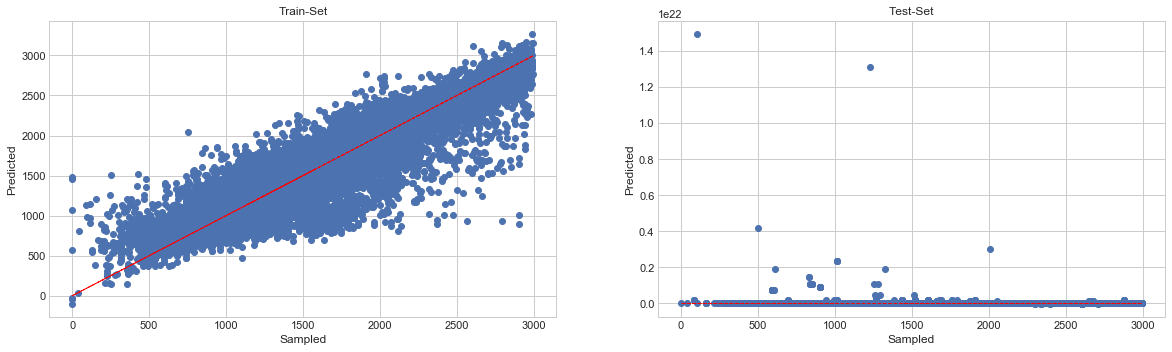

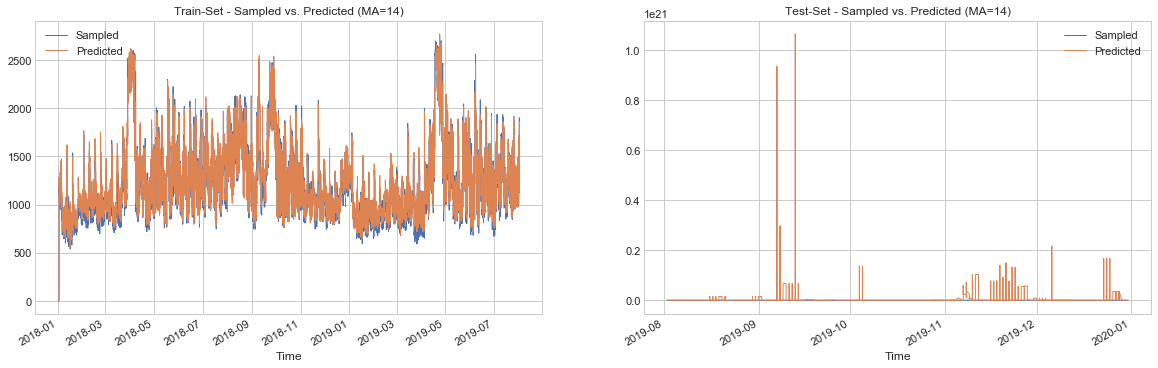

In [50]:
model_name = models[8]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = make_pipeline(StandardScaler(),
                          MLPRegressor(hidden_layer_sizes=(100, 100),
                                       tol=1e-2, 
                                       max_iter=500,
                                       random_state=0))

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### LSTM RNN (Tensorflow)

Recurrent Neural Networks (RNN) have been proven to efficiently solve sequence problems. Particularly, Long Short Term Memory Network (LSTM), which is a variation of RNN, is currently being used in a variety of domains to solve sequence problems.<br>
<br>
<div><img src="https://i.stack.imgur.com/Mpzfy.jpg" width="500"/></div>

In [51]:
def lstm_calculate_loss(model, dataset, dataset_idx, X_true, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = pd.DataFrame(Xpred, index=dataset_idx, columns=[dependent_var])

    # Ground Truth:
    Xtrue = X_true.copy()
    Xtrue = pd.DataFrame(Xtrue, index=dataset_idx, columns=[dependent_var])

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])
    
    # Plot:
    if plot_en:
        fig, axes = plt.subplots(2, 1, figsize=(30,15))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=axes[0])
        axes[0].set_title('Loss Distribution', fontsize=20)
        axes[0].set_xlabel('Loss Distribution', fontsize=15)
        #axes[0].set_xlim([0.0,.5])
        axes[1].set_title('Sampled vs. Predicted', fontsize=20)
        axes[1].set_xlabel('Time', fontsize=15)
        Xtrue[dependent_var].plot(subplots=True, ax=axes[1], color='Blue', label='Sampeld')
        Xpred[dependent_var].plot(subplots=True, ax=axes[1], color='Green', label='Predicted')
        axes[1].legend()
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

Model: lstm_rnn
Train on 48830 samples, validate on 2570 samples
Epoch 1/1000
48830/48830 - 2s - loss: 1882296.9021 - val_loss: 1923528.0546
Epoch 2/1000
48830/48830 - 1s - loss: 1855970.6503 - val_loss: 1892438.9627
Epoch 3/1000
48830/48830 - 1s - loss: 1829404.8839 - val_loss: 1865757.4807
Epoch 4/1000
48830/48830 - 1s - loss: 1797464.1125 - val_loss: 1833522.2333
Epoch 5/1000
48830/48830 - 1s - loss: 1765165.9697 - val_loss: 1801867.3939
Epoch 6/1000
48830/48830 - 1s - loss: 1739247.7575 - val_loss: 1776284.6925
Epoch 7/1000
48830/48830 - 1s - loss: 1716395.8155 - val_loss: 1752973.5518
Epoch 8/1000
48830/48830 - 1s - loss: 1694658.1902 - val_loss: 1730668.8224
Epoch 9/1000
48830/48830 - 1s - loss: 1672693.0643 - val_loss: 1707786.2312
Epoch 10/1000
48830/48830 - 1s - loss: 1649236.5730 - val_loss: 1683358.0421
Epoch 11/1000
48830/48830 - 1s - loss: 1624842.9526 - val_loss: 1659150.6696
Epoch 12/1000
48830/48830 - 1s - loss: 1600588.2690 - val_loss: 1634964.2053
Epoch 13/1000
48830/

48830/48830 - 1s - loss: 505656.6977 - val_loss: 484295.0559
Epoch 109/1000
48830/48830 - 1s - loss: 500940.4026 - val_loss: 477468.2832
Epoch 110/1000
48830/48830 - 1s - loss: 493346.6020 - val_loss: 470882.0525
Epoch 111/1000
48830/48830 - 1s - loss: 488458.3215 - val_loss: 464311.8588
Epoch 112/1000
48830/48830 - 1s - loss: 482166.6600 - val_loss: 457980.9584
Epoch 113/1000
48830/48830 - 1s - loss: 475582.3116 - val_loss: 451582.9240
Epoch 114/1000
48830/48830 - 1s - loss: 470535.6560 - val_loss: 445198.2326
Epoch 115/1000
48830/48830 - 1s - loss: 466362.1151 - val_loss: 438765.0790
Epoch 116/1000
48830/48830 - 1s - loss: 458509.3107 - val_loss: 431839.3695
Epoch 117/1000
48830/48830 - 1s - loss: 453178.6170 - val_loss: 425866.4913
Epoch 118/1000
48830/48830 - 1s - loss: 448347.4375 - val_loss: 419800.4313
Epoch 119/1000
48830/48830 - 1s - loss: 442537.4622 - val_loss: 413826.8423
Epoch 120/1000
48830/48830 - 1s - loss: 437842.3027 - val_loss: 408055.6884
Epoch 121/1000
48830/48830 

Epoch 216/1000
48830/48830 - 1s - loss: 158810.6219 - val_loss: 128462.3360
Epoch 217/1000
48830/48830 - 1s - loss: 156861.7579 - val_loss: 128078.1940
Epoch 218/1000
48830/48830 - 1s - loss: 156498.4773 - val_loss: 127136.1292
Epoch 219/1000
48830/48830 - 1s - loss: 154318.2541 - val_loss: 126770.4478
Epoch 220/1000
48830/48830 - 1s - loss: 152936.5464 - val_loss: 126432.9806
Epoch 221/1000
48830/48830 - 1s - loss: 151818.7018 - val_loss: 125754.7642
Epoch 222/1000
48830/48830 - 1s - loss: 150200.3928 - val_loss: 125307.9564
Epoch 223/1000
48830/48830 - 1s - loss: 148950.6235 - val_loss: 124253.7804
Epoch 224/1000
48830/48830 - 1s - loss: 148729.2957 - val_loss: 123649.1911
Epoch 225/1000
48830/48830 - 1s - loss: 146603.6820 - val_loss: 123006.3245
Epoch 226/1000
48830/48830 - 1s - loss: 145078.6389 - val_loss: 122449.5213
Epoch 227/1000
48830/48830 - 1s - loss: 144226.5632 - val_loss: 122198.9392
Epoch 228/1000
48830/48830 - 1s - loss: 145044.2026 - val_loss: 121782.1794
Epoch 229/10

Epoch 324/1000
48830/48830 - 1s - loss: 97103.6124 - val_loss: 137463.1852
Epoch 325/1000
48830/48830 - 1s - loss: 95553.1737 - val_loss: 137819.8620
Epoch 326/1000
48830/48830 - 1s - loss: 96640.4232 - val_loss: 139343.5379
Epoch 327/1000
48830/48830 - 1s - loss: 96399.9511 - val_loss: 138628.8408
Epoch 328/1000
48830/48830 - 1s - loss: 95722.4200 - val_loss: 139100.9395
Epoch 329/1000
48830/48830 - 1s - loss: 97201.6122 - val_loss: 138590.5438
Epoch 330/1000
48830/48830 - 1s - loss: 94850.6212 - val_loss: 139429.3959
Epoch 331/1000
48830/48830 - 1s - loss: 94301.6255 - val_loss: 139612.9185
Epoch 332/1000
48830/48830 - 1s - loss: 94480.0975 - val_loss: 140436.0477
Epoch 333/1000
48830/48830 - 1s - loss: 95384.4149 - val_loss: 140049.8480
Epoch 334/1000
48830/48830 - 1s - loss: 95361.2348 - val_loss: 141226.8431
Epoch 335/1000
48830/48830 - 1s - loss: 95536.0211 - val_loss: 141802.0512
Epoch 336/1000
48830/48830 - 1s - loss: 92910.8282 - val_loss: 143130.4935
Epoch 337/1000
48830/4883

Epoch 434/1000
48830/48830 - 1s - loss: 83373.9052 - val_loss: 154718.7860
Epoch 435/1000
48830/48830 - 1s - loss: 84511.0567 - val_loss: 155754.3142
Epoch 436/1000
48830/48830 - 1s - loss: 83534.1327 - val_loss: 156106.1186
Epoch 437/1000
48830/48830 - 1s - loss: 82111.0636 - val_loss: 156321.7762
Epoch 438/1000
48830/48830 - 1s - loss: 82057.8384 - val_loss: 156520.3817
Epoch 439/1000
48830/48830 - 1s - loss: 82182.5883 - val_loss: 154087.8098
Epoch 440/1000
48830/48830 - 1s - loss: 82228.6112 - val_loss: 157519.3383
Epoch 441/1000
48830/48830 - 1s - loss: 82886.5337 - val_loss: 155787.1861
Epoch 442/1000
48830/48830 - 1s - loss: 81739.2505 - val_loss: 156823.2131
Epoch 443/1000
48830/48830 - 1s - loss: 82836.6940 - val_loss: 156251.2579
Epoch 444/1000
48830/48830 - 1s - loss: 82455.5308 - val_loss: 156679.9437
Epoch 445/1000
48830/48830 - 1s - loss: 82378.6304 - val_loss: 155497.6646
Epoch 446/1000
48830/48830 - 1s - loss: 83445.6314 - val_loss: 155164.0746
Epoch 447/1000
48830/4883

Epoch 544/1000
48830/48830 - 1s - loss: 77501.5559 - val_loss: 157690.6116
Epoch 545/1000
48830/48830 - 1s - loss: 76516.5094 - val_loss: 158126.5223
Epoch 546/1000
48830/48830 - 1s - loss: 77231.7301 - val_loss: 158610.6273
Epoch 547/1000
48830/48830 - 1s - loss: 77000.2864 - val_loss: 158721.0080
Epoch 548/1000
48830/48830 - 1s - loss: 77473.4423 - val_loss: 157811.6887
Epoch 549/1000
48830/48830 - 1s - loss: 76888.7371 - val_loss: 159416.0131
Epoch 550/1000
48830/48830 - 1s - loss: 76183.6175 - val_loss: 158048.1310
Epoch 551/1000
48830/48830 - 1s - loss: 77550.8851 - val_loss: 158762.7081
Epoch 552/1000
48830/48830 - 1s - loss: 77200.6338 - val_loss: 157463.8106
Epoch 553/1000
48830/48830 - 1s - loss: 76250.4001 - val_loss: 159400.9579
Epoch 554/1000
48830/48830 - 1s - loss: 76362.2871 - val_loss: 157660.6211
Epoch 555/1000
48830/48830 - 1s - loss: 76305.6405 - val_loss: 158322.5987
Epoch 556/1000
48830/48830 - 1s - loss: 77432.8965 - val_loss: 159549.7372
Epoch 557/1000
48830/4883

Epoch 654/1000
48830/48830 - 1s - loss: 73063.0208 - val_loss: 161583.7783
Epoch 655/1000
48830/48830 - 1s - loss: 73811.5438 - val_loss: 161425.2646
Epoch 656/1000
48830/48830 - 1s - loss: 73494.5264 - val_loss: 160728.1445
Epoch 657/1000
48830/48830 - 1s - loss: 73407.2480 - val_loss: 159149.6250
Epoch 658/1000
48830/48830 - 1s - loss: 73074.8112 - val_loss: 161318.6781
Epoch 659/1000
48830/48830 - 1s - loss: 73270.8535 - val_loss: 159710.5540
Epoch 660/1000
48830/48830 - 1s - loss: 72747.5959 - val_loss: 159549.2390
Epoch 661/1000
48830/48830 - 1s - loss: 74759.9358 - val_loss: 161590.6693
Epoch 662/1000
48830/48830 - 1s - loss: 72499.3323 - val_loss: 160228.2840
Epoch 663/1000
48830/48830 - 1s - loss: 73109.4831 - val_loss: 160094.1548
Epoch 664/1000
48830/48830 - 1s - loss: 73444.3404 - val_loss: 159611.9983
Epoch 665/1000
48830/48830 - 1s - loss: 73575.9689 - val_loss: 159297.6067
Epoch 666/1000
48830/48830 - 1s - loss: 73016.2780 - val_loss: 160024.5265
Epoch 667/1000
48830/4883

Epoch 764/1000
48830/48830 - 1s - loss: 70877.6554 - val_loss: 160286.8321
Epoch 765/1000
48830/48830 - 1s - loss: 70815.4790 - val_loss: 159166.6596
Epoch 766/1000
48830/48830 - 1s - loss: 69976.5800 - val_loss: 158689.2535
Epoch 767/1000
48830/48830 - 1s - loss: 70481.6254 - val_loss: 159439.4678
Epoch 768/1000
48830/48830 - 1s - loss: 70503.2112 - val_loss: 160985.5722
Epoch 769/1000
48830/48830 - 1s - loss: 70906.5392 - val_loss: 158127.0055
Epoch 770/1000
48830/48830 - 1s - loss: 71223.9120 - val_loss: 157823.3580
Epoch 771/1000
48830/48830 - 1s - loss: 69427.7566 - val_loss: 157733.3553
Epoch 772/1000
48830/48830 - 1s - loss: 70161.0085 - val_loss: 160560.0517
Epoch 773/1000
48830/48830 - 1s - loss: 70731.5924 - val_loss: 160645.5433
Epoch 774/1000
48830/48830 - 1s - loss: 70226.0849 - val_loss: 157809.6941
Epoch 775/1000
48830/48830 - 1s - loss: 69905.4519 - val_loss: 159494.2906
Epoch 776/1000
48830/48830 - 1s - loss: 71344.8016 - val_loss: 160528.2090
Epoch 777/1000
48830/4883

Epoch 874/1000
48830/48830 - 1s - loss: 69476.9775 - val_loss: 157292.6586
Epoch 875/1000
48830/48830 - 1s - loss: 68361.1880 - val_loss: 155966.4322
Epoch 876/1000
48830/48830 - 1s - loss: 68675.2718 - val_loss: 155207.5204
Epoch 877/1000
48830/48830 - 1s - loss: 68731.0975 - val_loss: 157294.5180
Epoch 878/1000
48830/48830 - 1s - loss: 68526.5149 - val_loss: 155056.1177
Epoch 879/1000
48830/48830 - 1s - loss: 68609.3284 - val_loss: 154106.4099
Epoch 880/1000
48830/48830 - 1s - loss: 69269.5018 - val_loss: 155608.5912
Epoch 881/1000
48830/48830 - 1s - loss: 69425.9469 - val_loss: 154863.5925
Epoch 882/1000
48830/48830 - 1s - loss: 67762.6787 - val_loss: 152574.1541
Epoch 883/1000
48830/48830 - 1s - loss: 68787.1639 - val_loss: 153932.7775
Epoch 884/1000
48830/48830 - 1s - loss: 68873.6904 - val_loss: 155508.5873
Epoch 885/1000
48830/48830 - 1s - loss: 68655.3831 - val_loss: 152641.4478
Epoch 886/1000
48830/48830 - 1s - loss: 67153.9522 - val_loss: 155062.0635
Epoch 887/1000
48830/4883

Epoch 984/1000
48830/48830 - 1s - loss: 66862.8744 - val_loss: 153454.5718
Epoch 985/1000
48830/48830 - 1s - loss: 66897.4796 - val_loss: 155070.1484
Epoch 986/1000
48830/48830 - 1s - loss: 65472.8102 - val_loss: 154855.1399
Epoch 987/1000
48830/48830 - 1s - loss: 65856.1441 - val_loss: 154452.6927
Epoch 988/1000
48830/48830 - 1s - loss: 67382.1379 - val_loss: 153614.1168
Epoch 989/1000
48830/48830 - 1s - loss: 66818.4632 - val_loss: 153273.1218
Epoch 990/1000
48830/48830 - 1s - loss: 66595.9451 - val_loss: 153855.5962
Epoch 991/1000
48830/48830 - 1s - loss: 66781.9791 - val_loss: 153744.5099
Epoch 992/1000
48830/48830 - 1s - loss: 66674.9910 - val_loss: 154984.0046
Epoch 993/1000
48830/48830 - 1s - loss: 66354.6224 - val_loss: 153866.5491
Epoch 994/1000
48830/48830 - 1s - loss: 66589.5461 - val_loss: 153713.3543
Epoch 995/1000
48830/48830 - 1s - loss: 67103.6188 - val_loss: 153339.6159
Epoch 996/1000
48830/48830 - 1s - loss: 66397.9533 - val_loss: 153391.6545
Epoch 997/1000
48830/4883

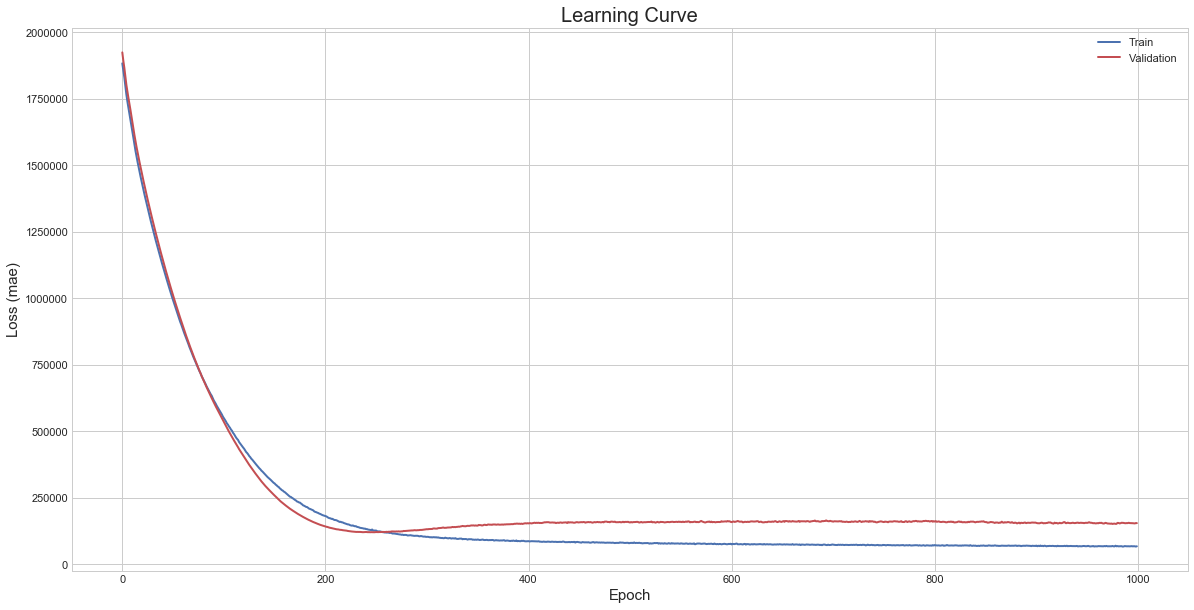

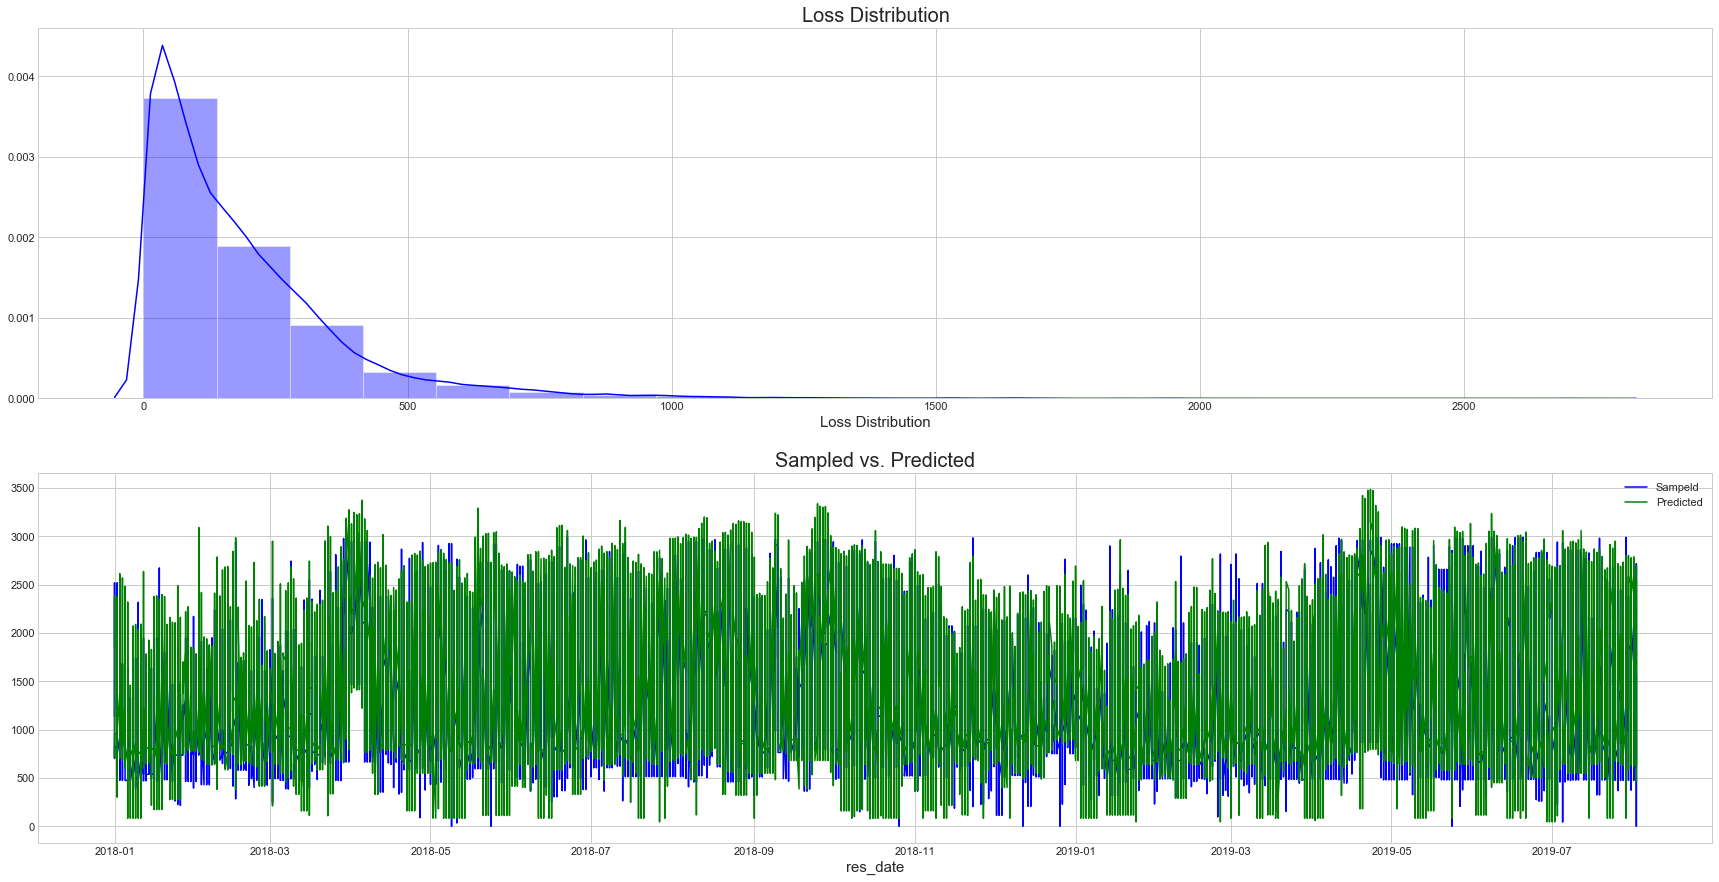

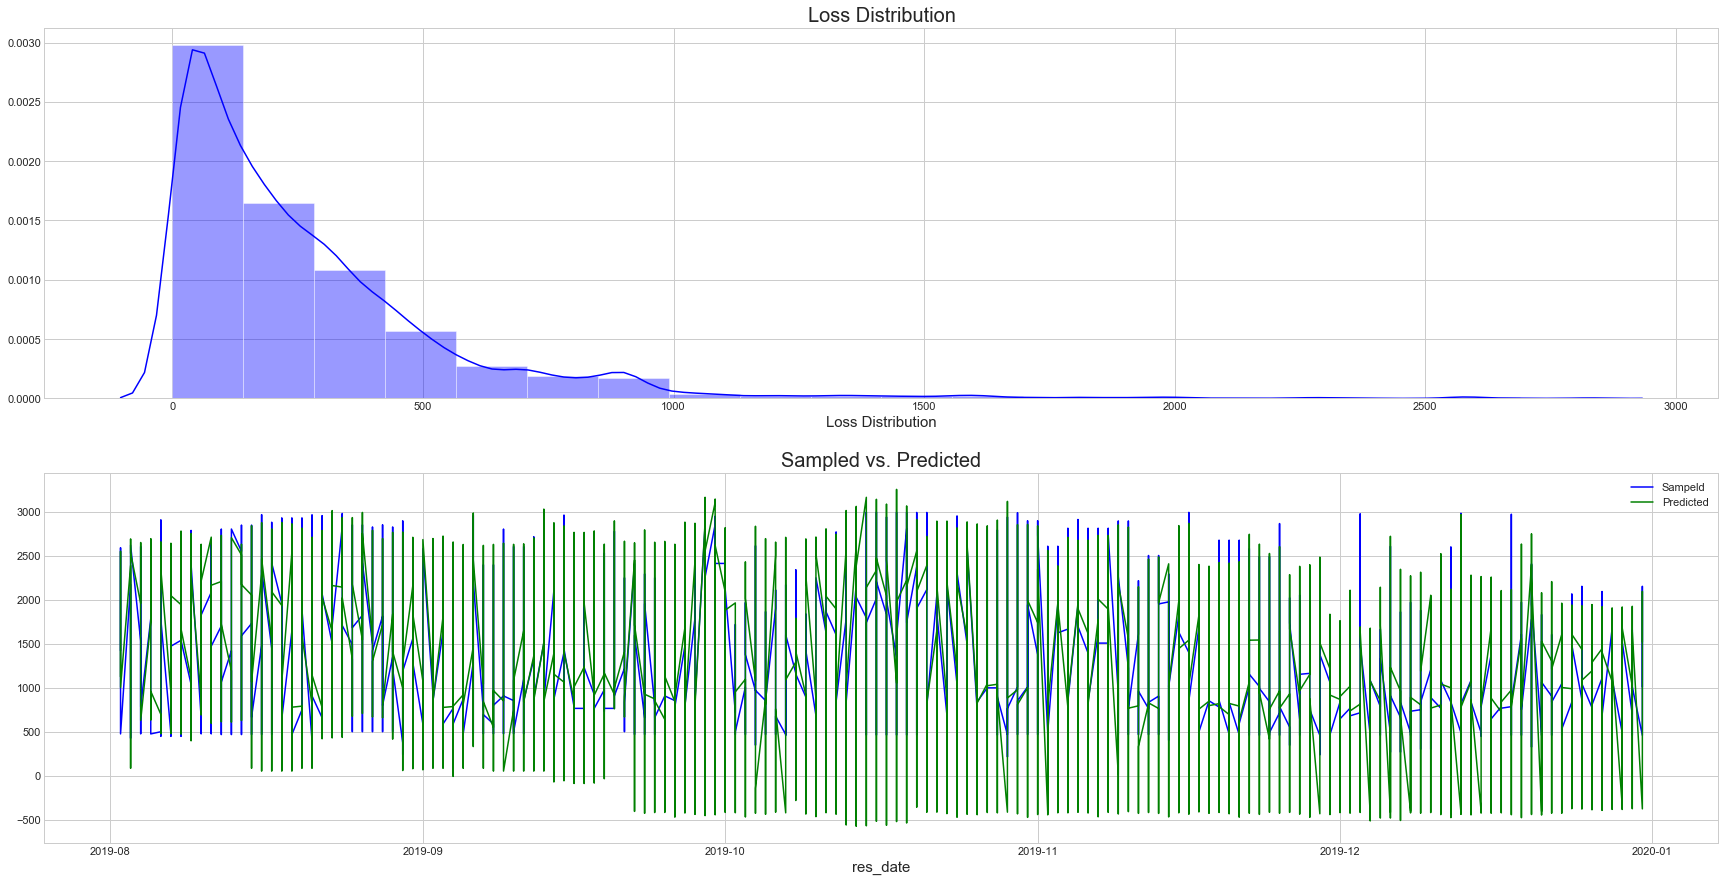

Train Accuracy: 0.79778 (loss MAE = 980.253)
Test Accuracy: 0.59842 (loss MAE = 508.959)


In [52]:
model_name = models[9]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()    

# Samples, TimeSteps, Features
X_train_shaped = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_shaped = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

# Samples, Features
y_train_shaped = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_shaped = y_test_np.reshape(y_test_np.shape[0], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:
    
    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    stacked_lstm = False
    n_nuerons = 128
    
    # Create the LSTM RNN model
    model = Sequential()
    if stacked_lstm:
        model.add(LSTM(n_nuerons, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.3))
        model.add(LSTM(n_nuerons/2, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/4, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/8, dropout=0.3))
    else:
        model.add(LSTM(n_nuerons, input_shape=(1, X_train.shape[1]), dropout=0.3))                      
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        y_train_shaped,
                        epochs=1000, 
                        batch_size=512,
                        validation_split=0.05,
                        verbose=2).history
    
    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())

# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = lstm_calculate_loss(
    model, X_train_shaped, X_train.index, y_train_shaped)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = lstm_calculate_loss(
    model, X_test_shaped, X_test.index, y_test_shaped)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: %.5f (loss MAE = %.3f)' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: %.5f (loss MAE = %.3f)' % (r2_tst, loss_mae_tst.iloc[-1]))

<hr>

### LSTM AutoEncoder (Tensorflow)

LSTM Autoencoders are composed by a simple LSTM encoder layer, followed by another simple LSTM decoder and by  TimeDistributed layer at the end.<br>
The idea here is to treat the dependant variable (y) as part of the features (X). We'll try to encode the whole set (Xy) and the decode it back.<br>
We will create a composite LSTM Autoencoder that has a single encoder and two decoders, one for reconstruction and one for prediction.<br>
<br>
<div><img src="https://miro.medium.com/max/1400/1*ZAorCoNenSYwDhTkFzqEGw.jpeg" width="500"/></div>

In [53]:
def autoencoder_calculate_loss(model, dataset, dataset_cols, dataset_idx, scaler_xy, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = Xpred.reshape(Xpred.shape[0], Xpred.shape[1])
    Xpred = pd.DataFrame(Xpred, columns=dataset_cols)
    Xpred.index = dataset_idx

    # Ground Truth:
    Xtrue = dataset.reshape(dataset.shape[0], dataset.shape[1])
    Xtrue = pd.DataFrame(Xtrue, columns=dataset_cols)
    Xtrue.index = dataset_idx

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # UnScaling:
    Xy_dummy = dataset.copy()
    Xy_dummy = Xy_dummy.reshape(Xy_dummy.shape[0], Xy_dummy.shape[1])
    Xy_dummy = pd.DataFrame(Xy_dummy, columns=dataset_cols)
    Xy_dummy.index = dataset_idx
    Xy_dummy[dependent_var] = Xpred[dependent_var].values
    y_pred = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    Xy_dummy[dependent_var] = Xtrue[dependent_var].values
    y_true = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    
    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])    
    
    # Plot:
    if plot_en:
        
        y_smp = pd.DataFrame(y_true, index=dataset_idx)
        y_prd = pd.DataFrame(y_pred, index=dataset_idx)

        y_smp_ma = y_smp.groupby(y_smp.index).mean().rolling(window=14).mean().fillna(0)
        y_prd_ma = y_prd.groupby(y_prd.index).mean().rolling(window=14).mean().fillna(0)

        y_ma = pd.concat([y_smp_ma, y_prd_ma], axis=1)
        y_ma.columns = ['Sampled', 'Predicted']
        
        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=ax)
        ax.set_title('Loss Distribution', fontsize=20)
        ax.set_xlabel('Loss Distribution', fontsize=15)
        #ax.set_xlim([0.0,.5])
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        y_ma.plot(ax=ax, linewidth=1)
        ax.xaxis_date()
        ax.set_title('Sampled vs. Predicted (MA=14)')
        ax.set_xlabel('Time')
        ax.legend()
        fig.autofmt_xdate()        
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

In [54]:
%%script false --no-raise-error

model_name = models[10]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = Xy_train.to_numpy()
X_test_np = Xy_test.to_numpy()

# Reshape inputs for LSTM [samples, features, timesteps]
X_train_shaped = X_train_np.astype(np.float64).reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_shaped = X_test_np.astype(np.float64).reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:

    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)

    sequence_length = 4

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    # Create the autoencoder model
    sequence_length = X_train_np.shape[1]
    inputs_ae = Input(shape=(sequence_length, 1))
    encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
    out_ae = TimeDistributed(Dense(1))(decoded_ae)

    model = Model(inputs_ae, out_ae)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        X_train_shaped,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=2,
                        shuffle=True).history

    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())
    
# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = autoencoder_calculate_loss(
    model, X_train_shaped, Xy_train.columns, Xy_train.index, scaler_xy_train)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = autoencoder_calculate_loss(
    model, X_test_shaped, Xy_test.columns, Xy_test.index, scaler_xy_test)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_tst, loss_mae_tst.iloc[-1]))

### Forecasting

WIP

<hr>

# Statistical Forecasting

### SARIMAX

An ARIMA model is one where a time series get differenced d times to make it stationary, and then combine the AR and the MA terms.   
So the equation becomes:
<br>
<br>
$
\begin{align}
Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p} + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}
\end{align}
$
<br>
<br>
Linear regression models work best when the predictors are not correlated and are independent of each other.   
Hence, the first step to build an ARIMA model is to __make the time series stationary__.   
<br>
The __SARIMAX__ extension of ARIMA that explicitly models the seasonal element in univariate data.
<br>
<br>
There are three __trend elements__ (same as in the ARIMA model):
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order

There are four __seasonal elements__ (not part of ARIMA):
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

In [55]:
def test_adf(series):
    '''
    Augmented Dickey-Fuller is the most popular statistical method to find if the series is stationary or not.
    It is also called as Unit Root Test.
    If value of p <0.05, then the data is stationary else the data is not stationary.
    '''
    
    dfout = {}
    dftest = sm.tsa.adfuller(series.dropna(), 
                             autolag='AIC', 
                             regression='ct')
    
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    
    adf_p_value = dftest[1]
    
    is_stationary = adf_p_value <= 0.05
    
    if is_stationary:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary (p=%.5f)" % adf_p_value)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary (p=%.2f) for " % adf_p_value)
    
    return is_stationary

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary (p=0.00000)
Model: sarima
(p,d,q) = (1, 0, 2)
(P,D,Q,s) = (0, 0, 0, 1)
AIC = -41641.91


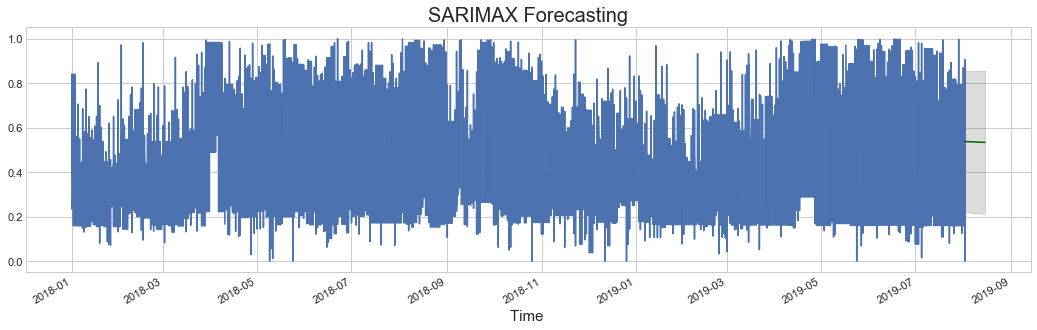

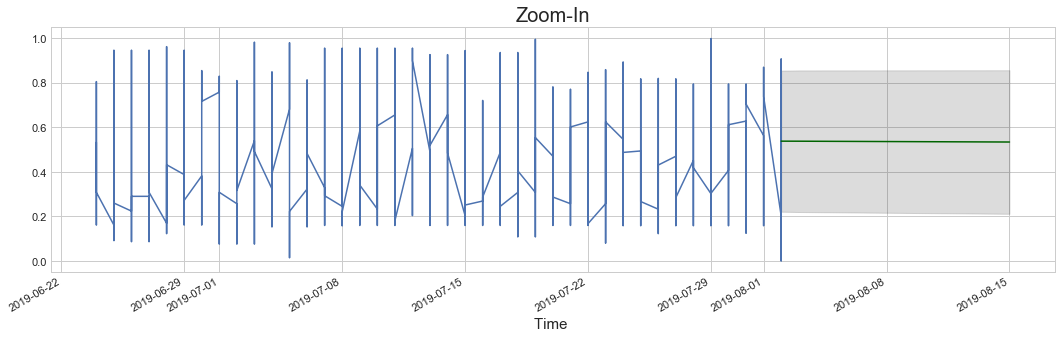

In [56]:
n_periods = 14  # amount of future time-samples to predict
n_zoom_in = 4000  # plotting zoom-in (last 'n_zoom_in' time-samples) 

# Normalization
sc_in = MinMaxScaler(feature_range=(0, 1))
out = pd.DataFrame(sc_in.fit_transform(pd.DataFrame(y_train)))
out.rename(columns={0:dependent_var}, inplace=True)

# Stationarity check
is_stationary = test_adf(out[dependent_var])
if not is_stationary:
    test_adf(out.diff())
    
model_name = models[11]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)
    
else:

    # Create the arima model + Auto Fit:
    model = auto_arima(out,
                       start_p=1,        # min_p (AR term)
                       start_q=1,        # min_q (MA term)
                       test='adf',       # use ADF test to find optimal 'd'
                       max_p=3,          # max p (AR term)
                       max_q=3,          # max q (MA term)
                       m=1,              # frequency of series
                       d=None,           # let model determine 'd'
                       seasonal=True,    # True for SARIMAX, False for No Seasonality
                       start_P=0,        # min_P (AR term of the seasonal model)
                       D=None,           # let model determine 'D'
                       trace=False,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

    # Save the model
    joblib.dump(model, model_file)

print('(p,d,q) = %s' % str(model.get_params()['order']))
print('(P,D,Q,s) = %s' % str(model.get_params()['seasonal_order']))        
print('AIC = %.2f' % model.aic())

out.index = y_train.index

# Forecast
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range(start=out.index[-1], periods=n_periods, freq='D'))

lower_series = pd.Series(confint[:, 0], index=fc_series.index)
upper_series = pd.Series(confint[:, 1], index=fc_series.index)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('SARIMAX Forecasting', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out)
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('Zoom-In', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out[-n_zoom_in:])
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

### FBProphet

[Facebook Prophet](https://facebook.github.io/prophet/) is an additive regression model with four main components:
- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model: fbprophet


/usr/local/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



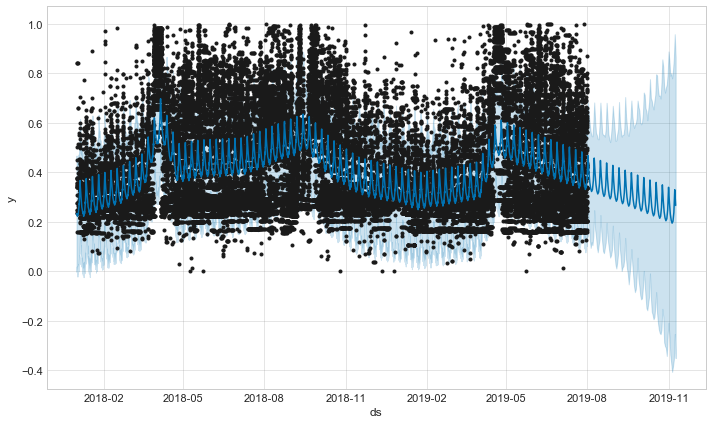

In [57]:
# Change the column names according to Prophet's guidelines:
out_df = out.copy().reset_index()
out_df.columns = ['ds', 'y']
out_df.T

# Split into a train/test set:
prediction_size = 100
train_df = out_df[:-prediction_size]

# Build an Prophet model:
model_name = "fbprophet"
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    model = Prophet()
    model.fit(train_df)
    
    # Save the model
    joblib.dump(model, model_file)
        
# Forecast:
future_df = model.make_future_dataframe(periods=prediction_size)
forecast_df = model.predict(future_df)
forecast_df.head()

# Plot forecast
model.plot(forecast_df)
plt.show()

# Plot forecast components:
#model.plot_components(forecast_df)
#plt.show()

<hr>

# Summary

In [58]:
summary = { 'train_accuracy': {}, 
            'test_accuracy': {} } 

for model_name in models:
    
    if model_name == 'sarima' or model_name == 'fbprophet' or model_name == 'lstm_autoencoder':
        continue
    
    model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

    if path.isfile(model_file):
        
        model = joblib.load(model_file)
        
        if type(model) is dict:
            summary['train_accuracy'][model_name] = model['r2_train']
            summary['test_accuracy'][model_name] = model['r2_test']
        else:
            summary['train_accuracy'][model_name] = model.score(X_train, y_train)
            summary['test_accuracy'][model_name] = model.score(X_test, y_test)
    
    else:
        print("Skipping: %s" % model_file)
          
summary_df = pd.DataFrame(summary).astype(float).round(4)
summary_df[abs(summary_df)>1] = 0
display(summary_df)

,train_accuracy,test_accuracy
linear_regressor,0.7983,0.0000
ridge_regressor,0.8005,0.8040
lasso_regressor,0.8004,0.8028
elasticnet_regressor,0.7779,0.7624
supportvect_regressor,0.7951,0.7016
decisiontree_regressor,0.9940,0.5724
randomforest_regressor,0.5824,0.5868
xgboost_regressor,0.8276,0.7912
mlp_regressor,0.9242,0.0000
lstm_rnn,0.7978,0.5984


<hr>

In [59]:
print('Completed')

Completed
